# PYMC vs traditional machine learning models for MMM

This notebook highlights how MMM can be built leveraging different modelling approaches. 

Its purpose is to show the benefits how probabilistic (bayesian) over frequencist models especially when you have some knowledge domain that you want to leverage and you start facing more complex data patterns.

The notebook is inspired from: 
  * [Juan Orduz](https://juanitorduz.github.io/)'s blog post: ["Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns"](https://juanitorduz.github.io/pymc_mmm/)
  * Slava Kisilevich's blog post: [Improving Marketing Mix Modeling Using Machine Learning Approaches](https://towardsdatascience.com/improving-marketing-mix-modeling-using-machine-learning-approaches-25ea4cd6994b/)

Synthetic data generation is available through MMMDataGenerator class. It makes parameter recovery possible to assess modelling. 

In [10]:
import numpy as np
import pandas as pd
import pytensor.tensor as pt
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from traditional_models import *
import pymc as pm
import arviz as az
import warnings
from pymc_marketing.prior import Prior
from matplotlib.ticker import FuncFormatter


import sys
import os
os.chdir('..')

from data_generator import MMMDataGenerator
from data_visualizer import MMMVisualizer
from utils import (approx_hsgp_hyperparams,
                    nrmse,
                    rssd,
                    calculate_spend_effect_share,
                    plot_spend_vs_effect_share,
                    plot_shap_vs_spend,
                    shap_feature_importance)




warnings.filterwarnings('ignore', category=UserWarning)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Synthethic Data Generation

In [11]:
countries = ['US'] # We generate data for several countries with different sparcity patterns but let's keep it simple in this article
channels = ['TV', 'Digital'] # 2 channels with different patterns.
n_dates = 53*4 # About 4 year data

# Generate data
generator = MMMDataGenerator(seed=42) # seed parameter to make data reproductible

# Let run generate_dataset method!
dataset, global_params, country_params = generator.generate_dataset(
    n_dates=n_dates,
    countries=countries,
    channels=channels)


In [12]:
dataset, global_params, country_params, _ = generator.generate_dataset_with_dynamics(n_dates=n_dates,
    countries=countries,
    channels=channels,
    apply_dynamic_effects=False # Variable that add time varying coefficients for media effects
    )

## Visualization

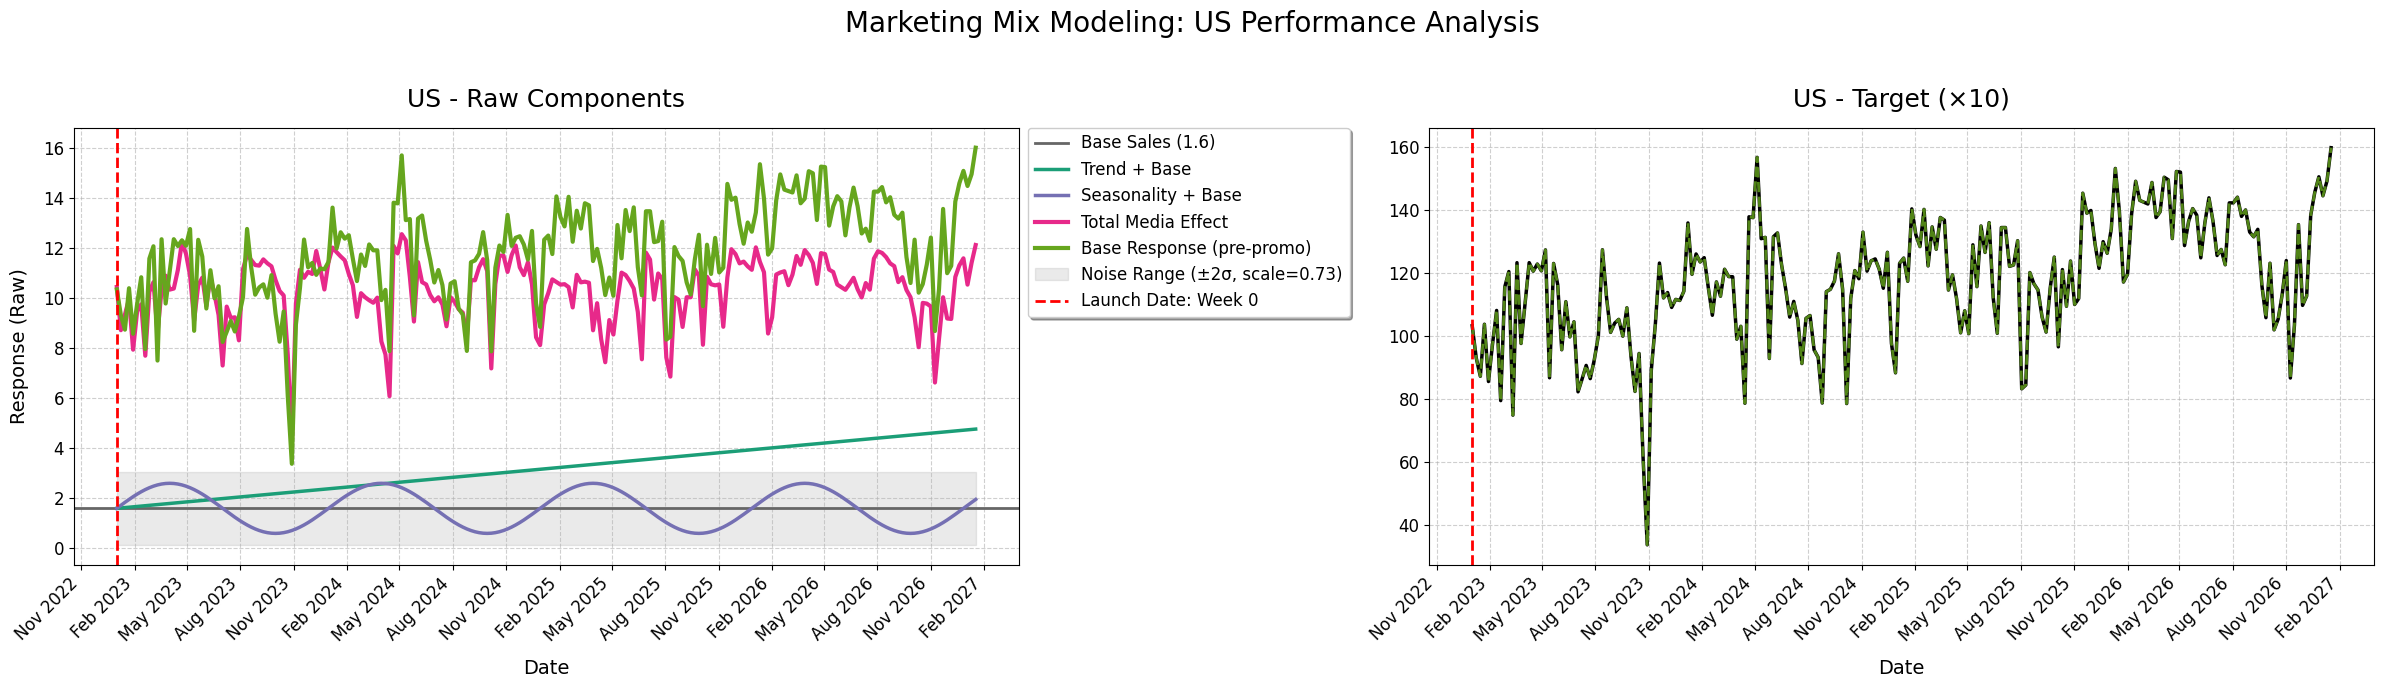

In [13]:
visualizer = MMMVisualizer()
country_subset = ['US']  # Focus on one country for clarity

components_basic = {
    'base_sales': True,
    'trend': True,
    'seasonality': True,
    'individual_channels': False,
    'total_media': True,
    'base_response': True,
    'noise_line': False,
    'noise_range': True,
    'target': True,
    'scaled_base': True,
    'promo_effects': False
}
fig = visualizer.plot_contributions(dataset, country_params, country_subset, components_basic)

## Very Basic EDA

By checking the right chart, we may notice: 
  * a positive trend
  * some seasonality with spikes around Feb-May and low momemtum between Aug-Nov 

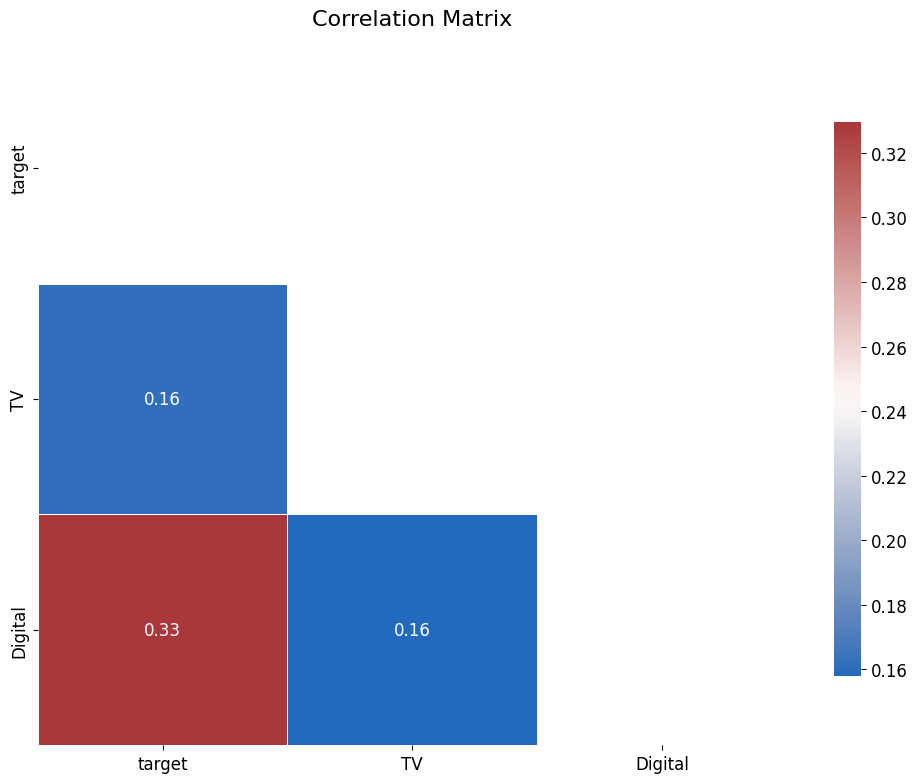

In [14]:
target = pd.DataFrame({"target": dataset.target.sel(country=countries).to_numpy().flatten()})
spends_array = dataset.spends.sel(country=countries).to_numpy().reshape(-1, 2)
spends = pd.DataFrame(spends_array, columns=channels)

# Combine for correlation matrix
combined = pd.concat([target, spends], axis=1)

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(combined.corr(), dtype=bool))  # Create mask for upper triangle
sns.heatmap(
    combined.corr(),
    annot=True,
    fmt=".2f",
    cmap="vlag",
    mask=mask,
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

We see a weak correlation between digital spend and target and low correlation between channels

### Media effect visualization

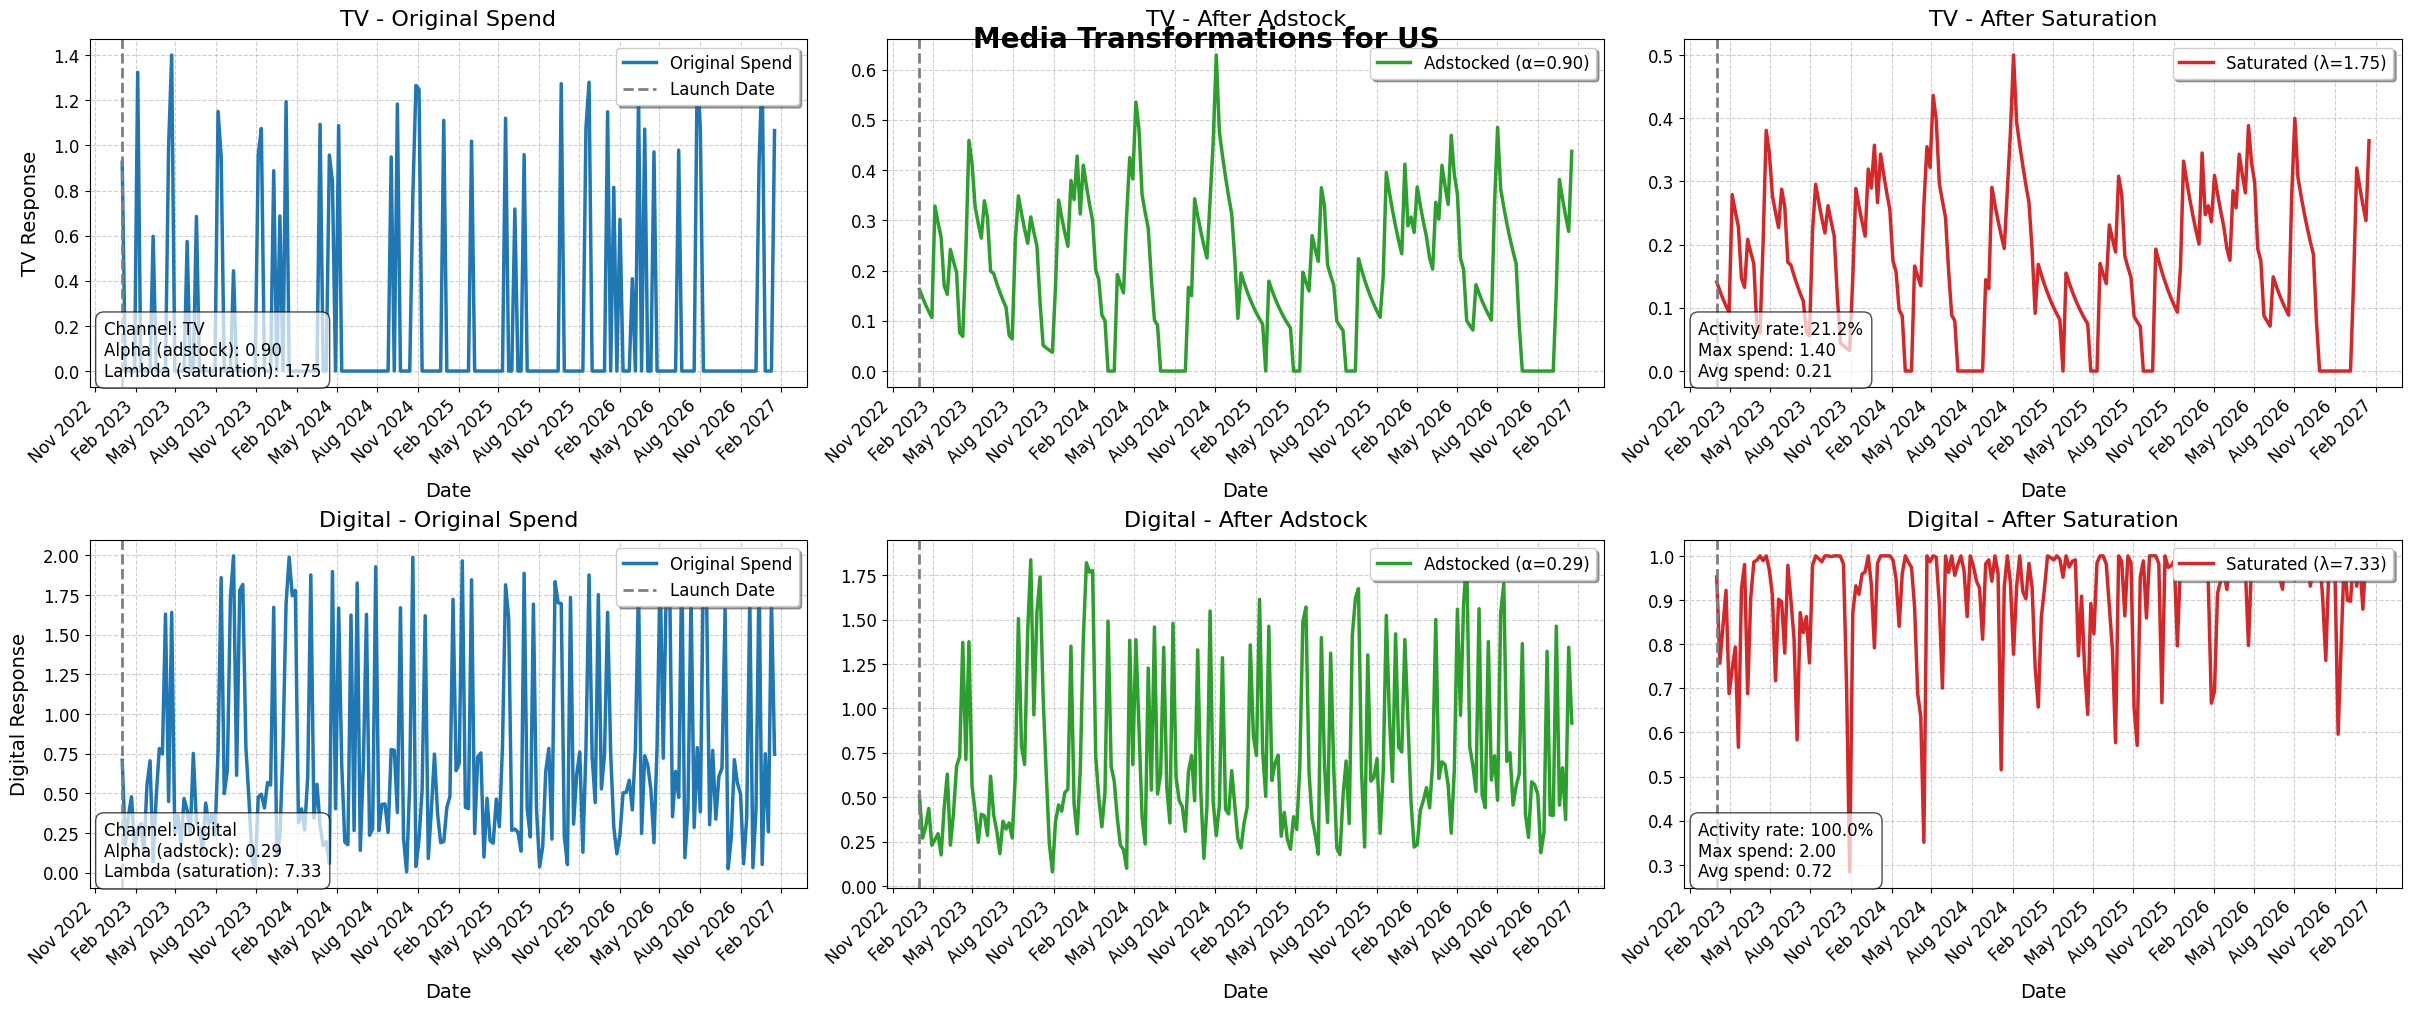

In [ ]:
fig_2 = visualizer.plot_media_transformations(dataset, country_params, countries)

This is unobserved data but it helps understand the true concepts of carryover and channel saturation as explained in the following paper [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017)](https://research.google/pubs/pub46001/)

## Media transformation functions

In [7]:
def geometric_adstock(x, alpha, l_max, normalize):
    """Vectorized geometric adstock transformation."""
    # Make sure x is treated as a vector if it's 1D
    x = pt.as_tensor_variable(x)

    # Create shifted versions of x
    cycles = [
        pt.concatenate(tensor_list=[pt.zeros(shape=x.shape)[:i], x[: x.shape[0] - i]])
        for i in range(l_max)
    ]

    # Stack the cycles into a single tensor
    x_cycle = pt.stack(cycles)

    # For 1D input, the shape is now (l_max, len(x))
    if x.ndim == 1:  # If x is a vector
        x_cycle = pt.transpose(x_cycle, axes=[1, 0])

        # Create decay weights
        w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])

        # Reshape for broadcasting
        w = w.reshape([1, l_max])

        if normalize:
            w = w / pt.sum(w, axis=1, keepdims=True)

        # Sum along the last dimension (axis=1)
        return pt.sum(x_cycle * w, axis=1)

    else:
        # We want (x.shape[0], x.shape[1], l_max)
        x_cycle = pt.transpose(x_cycle, axes=[1, 2, 0])

        # Create decay weights
        w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])

        # Reshape for broadcasting
        w = w.reshape([1, 1, l_max])

        if normalize:
            # Normalize the weights
            w = w / pt.sum(w, axis=2, keepdims=True)

        # Sum along the last dimension (axis=2)
        return pt.sum(x_cycle * w, axis=2)



def logistic_saturation(x, lam):
    """Logistic saturation transformation."""
    return (1 - pt.exp(-lam * x)) / (1 + pt.exp(-lam * x))

### Adstock function

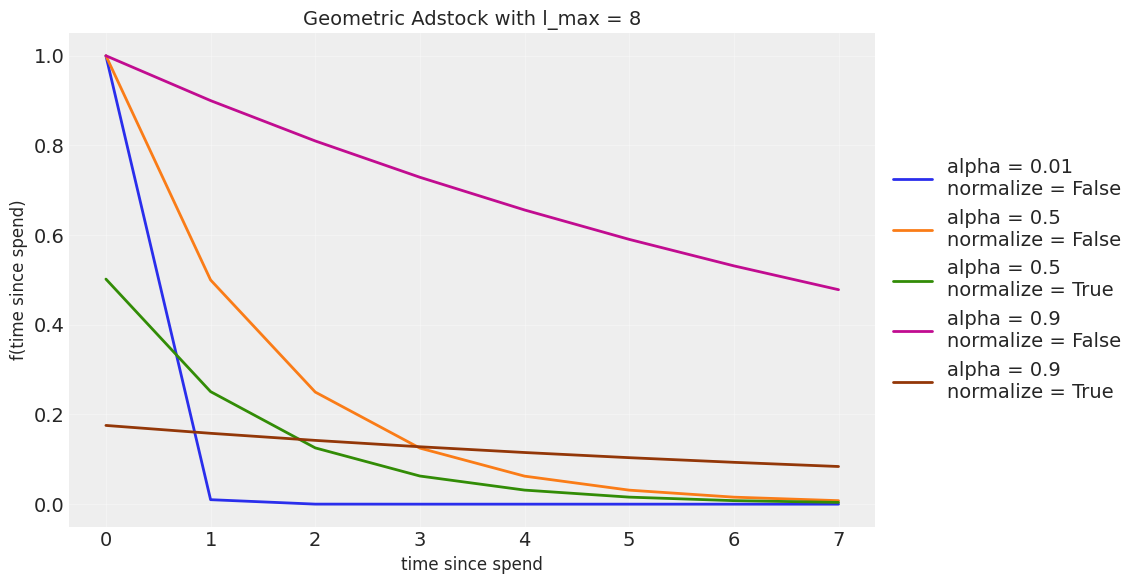

In [8]:
# Set up the plot style
plt.style.use('arviz-darkgrid')
plt.figure(figsize=(10, 6))

# Create a spike input (impulse) to see the decay pattern
# This simulates a single advertising event at time 0
t_max = 8
x = np.zeros(t_max)
x[0] = 1.0  # Single unit of spend at time 0

# Try different alpha values
alphas = [0.01, 0.5, 0.9]
normalize_options = [False, True]

# Plot each combination
for alpha in alphas:
    for normalize in normalize_options:
        # Skip some combinations to avoid too many lines
        if alpha == 0.01 and normalize:
            continue

        # Apply geometric adstock to the impulse
        y = geometric_adstock(x, alpha=alpha, l_max=t_max, normalize=normalize)

        # Create label with parameter values
        label = f"alpha = {alpha}\nnormalize = {normalize}"

        # Plot the decay curve
        plt.plot(range(t_max), y.eval(), linewidth=2, label=label)

# Add labels and title
plt.xlabel('time since spend', fontsize=12)
plt.ylabel('f(time since spend)', fontsize=12)
plt.title(f'Geometric Adstock with l_max = {t_max}', fontsize=14)

# Adjust legend position
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

We see that:
* **Alpha parameter effect:** The bigger the alpha value, the bigger the carryover effect
  * α = 0.01: Effects disappear almost immediately
  * α = 0.5: Effects persist for a moderate amount of time
  * α = 0.9: Effects persist for a long time
* **Normalize parameter effect:** When normalize is set to True:
  * The curves are scaled so the area under the curve equals 1
  * This creates a less dramatic initial descent compared to non-normalized curves
  * Normalization makes it easier to compare relative shapes of different alpha values

### Saturation function

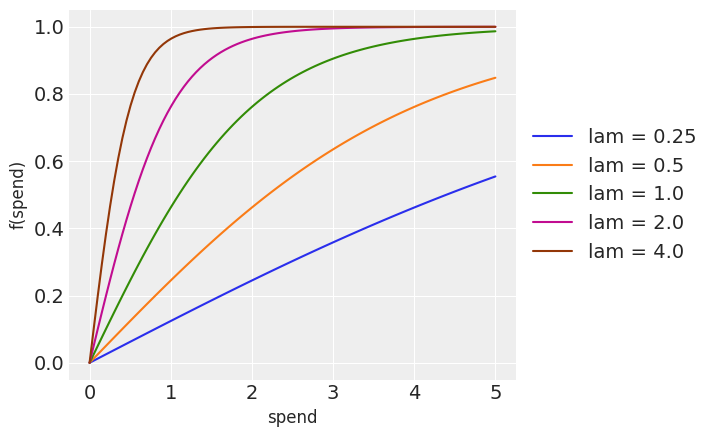

In [9]:
plt.style.use('arviz-darkgrid')
lam = np.array([0.25, 0.5, 1, 2, 4])
x = np.linspace(0, 5, 100)
ax = plt.subplot(111)
for l in lam:
    y = logistic_saturation(x, lam=l).eval()
    plt.plot(x, y, label=f'lam = {l}')
plt.xlabel('spend', fontsize=12)
plt.ylabel('f(spend)', fontsize=12)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



We see that:
* **Lambda parameter effect:** The lambda value controls the saturation rate
  * λ = 0.5: Very gradual saturation (almost linear for small input values)
  * λ = 2.0: Moderate saturation effect with diminishing returns beginning earlier
  * λ = 4.0: Aggressive saturation with strong diminishing returns at lower spend levels
* **Key characteristics:**
  * The function is monotonically increasing (more input always yields more output)
  * As input increases, the marginal effect decreases (diminishing returns)
  * Higher lambda values cause the curve to "bend" more quickly, indicating earlier diminishing returns
  * The function approaches an asymptotic maximum value as input increases
* **Marketing interpretation:**
  * Captures the concept that there is a limit to advertising effectiveness
  * Reflects how additional media spending yields less incremental response after a certain point
  * Can be used to identify the "efficient frontier" of advertising spend

## Modelling

We want to compare two modelling techniques trying to fit the sales pattern in the US: 
  * a **traditional frequencist models** (GBM, linear regression and ensemble) 
  * a **bayesian model** (pymc)
    
For both models, we assume: 
  * there is a positive trend 
  * there is first an adstock transformation and then a saturation transformation applied to the media spends. However, we don't know the parameters. This is what we are trying to estimate. 
  * there is a seasonality with an order 2 (we estimate 2 cycles max per year)

## Dataset prep

In [10]:
# Media features
media_columns = ["TV_spend", "Digital_spend"]
spend_df = pd.DataFrame(dataset.sel(country="US").spends, columns=media_columns)

# Trend features

trend = pd.DataFrame({"trend": np.arange(0,len(spend_df))// len(spend_df) })


In [11]:
# Fourier features

n_order = 2
periods = dataset.date.dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

## Train test split

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
import optuna
import shap

# Now let's run the full MMM analysis
def run_mmm_analysis(X, y, media_columns, alpha_ranges, lambda_ranges, test_size=20, n_trials=5):
    """
    Run a complete MMM analysis with all components from the article

    Parameters:
    -----------
    X : DataFrame
        Feature data
    y : Series
        Target data
    media_columns : list
        List of media columns to analyze
    alpha_ranges : dict
        Ranges for adstock parameters
    lambda_ranges : dict
        Ranges for lambda parameters if applied
    test_size : int
        Size of test set
    n_trials : int
        Number of optimization trials
    """
    print("Starting MMM Analysis...\n")

    # Split data for evaluation
    train_indices = list(range(len(X) - test_size))
    test_indices = list(range(len(X) - test_size, len(X)))

    # For optimization, use only the training data
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]

    # 1. Run baseline models for comparison
    print("1. Training models for comparison...")

    # Train LinearRegression model
    print("  Training Linear Regression model...")
    model_lr = MMM_Linear(alpha_ranges=alpha_ranges, lambda_ranges=lambda_ranges, l_max=8, apply_saturation=False)
    study_lr = model_lr.optimize(
        X=X_train,
        y=y_train,
        media_cols=media_columns,
        n_trials=n_trials ,  # Use fewer trials for baseline
        cv_splits=5,
        test_size=15,
        is_multiobjective=False
    )
    model_lr.fit(X_full=X, y_train=y_train, train_indices=train_indices, media_cols=media_columns)
    # Reset before second run


    # # Train LinearRegressionScaled model
    # print("  Training Linear Regression model Scaled...")
    # model_lr_scaled = MMM_LinearRegressionScaler(alpha_ranges=alpha_ranges, l_max=8)
    # study_lr_scaled = model_lr_scaled.optimize(
    #     X=X_train,
    #     y=y_train,
    #     media_cols=media_columns,
    #     n_trials=n_trials ,  # Use fewer trials for baseline
    #     cv_splits=5,
    #     test_size=15,
    #     is_multiobjective=True
    # )
    # model_lr_scaled.fit(X_full=X, y_train=y_train, train_indices=train_indices, media_cols=media_columns)

    # Train GradientBoosting model
    print("  Training Gradient Boosting model...")
    #model_gb = MMM_GradientBoosting(alpha_ranges=alpha_ranges, l_max=8)
    model_gb = MMM_TreeBased(alpha_ranges=alpha_ranges, l_max=8, model_type='gb')
    study_gb = model_gb.optimize(
        X=X_train,
        y=y_train,
        media_cols=media_columns,
        n_trials=n_trials,  # Use fewer trials for baseline
        cv_splits=5,
        test_size=15,
        is_multiobjective=False
    )
    model_gb.fit(X_full=X, y_train=y_train, train_indices=train_indices, media_cols=media_columns)

    # Train Ensemble model
    print("  Training Ensemble model...")
    model_ensemble = MMM_EnsembleBased(alpha_ranges=alpha_ranges, l_max=8)
    study_ensemble = model_ensemble.optimize(
        X=X_train,
        y=y_train,
        media_cols=media_columns,
        n_trials=n_trials,
        cv_splits=5,
        test_size=15,
        is_multiobjective=False
    )
    model_ensemble.fit(X_full=X, y_train=y_train, train_indices=train_indices, media_cols=media_columns)

    # 2. Evaluate models
    print("\n2. Evaluating models...")

    # Get predictions
    y_pred_lr = model_lr.predict(test_indices=test_indices)
    # y_pred_lr_scaled = model_lr_scaled.predict(test_indices=test_indices)
    y_pred_gb = model_gb.predict(test_indices=test_indices)
    y_pred_ensemble = model_ensemble.predict(test_indices=test_indices)

    # Calculate metrics
    results = {}

    for name, preds, model in [
        ("Linear Regression", y_pred_lr, model_lr),
        # ("Linear Regression Scaled", y_pred_lr_scaled, model_lr_scaled),
        ("Gradient Boosting", y_pred_gb, model_gb),
        ("Ensemble", y_pred_ensemble, model_ensemble)
    ]:
        # Basic metrics
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)
        mape = mean_absolute_percentage_error(y_test, preds)
        nrmse_val = nrmse(y_test, preds)

        print(f"  {name} Results:")
        print(f"    RMSE:  {rmse:.2f}")
        print(f"    R²:    {r2:.4f}")
        print(f"    MAPE:  {mape:.4f}")
        print(f"    NRMSE: {nrmse_val:.4f}")

        results[name] = {
            "model": model,
            "predictions": preds,
            "rmse": rmse,
            "r2": r2,
            "mape": mape,
            "nrmse": nrmse_val
        }

    # 3. Plot predictions
    print("\n3. Plotting predictions vs actual...")
    plt.figure(figsize=(15, 8))
    plt.plot(range(len(y_test)), y_test, 'k-', linewidth=2, label='Actual')

    colors = ['b', 'g', 'r', 'c']  # Blue, green, red, cyan
    styles = ['-', '--', '-.', ':']  # Solid, dashed, dash-dot, dotted


    for i, (name, res) in enumerate(results.items()):
        plt.plot(
            range(len(y_test)),
            res["predictions"],
            f"{colors[i]}{styles[i]}",
            linewidth=2,
            label=f'{name} (R²={res["r2"]:.4f})'
        )

    plt.title('Model Comparison: Predictions vs Actual', fontsize=16)
    plt.xlabel('Time Period', fontsize=14)
    plt.ylabel('Target Value', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4. SHAP Analysis for the best model
    print("\n4. SHAP Analysis for the Ensemble model...")

    # Get the best model
    best_model_name = max(results, key=lambda x: results[x]['r2'])
    best_model = results[best_model_name]['model']
    print(best_model.model_type)

    if best_model.model_type == 'lr':
        X_test_transformed = best_model.X_full_transformed.iloc[test_indices]
    else:
        X_test_transformed = best_model.X_full_adstocked.iloc[test_indices]
    print(f"  Using {best_model_name} for SHAP analysis (best R²)")

    # Create SHAP values based on model type
    try:
        # Try to get model attribute using appropriate attribute name
        if hasattr(best_model, 'model'):
            model_attr = best_model.model
        elif hasattr(best_model, 'tree_model'):
            # For the simplified ensemble class (which is now just GB)
            model_attr = best_model.tree_model
        else:
            # Fallback
            model_attr = best_model

        # Create explainer based on model type
        if isinstance(model_attr, (GradientBoostingRegressor, RandomForestRegressor)):
            explainer = shap.TreeExplainer(model_attr)
        else:
            explainer = shap.LinearExplainer(model_attr, X_test_transformed)

        # Get SHAP values
        shap_values = explainer.shap_values(X_test_transformed)

        # Create DataFrame of SHAP values
        df_shap_values = pd.DataFrame(shap_values, columns=X_test_transformed.columns)

        # Plot SHAP summary
        print("  Plotting SHAP Feature Importance...")
        shap_feature_importance(df_shap_values, X_test_transformed)

    except Exception as e:
        print(f"Error in SHAP analysis: {e}")
        # Create empty SHAP values for media channels to continue analysis
        df_shap_values = pd.DataFrame(0, index=range(len(test_indices)), columns=X_test_transformed.columns)
        print("  Using placeholder SHAP values to continue analysis")

    # 5. Spend vs Effect Analysis
    print("\n5. Spend vs Effect Analysis...")

    # Get original test data
    X_test_original = X.iloc[test_indices]

    # Calculate spend effect share
    spend_effect_share = calculate_spend_effect_share(
        df_shap_values=df_shap_values,
        media_channels=media_columns,
        df_original=X_test_original
    )

    # Calculate RSSD
    rssd_value = rssd(
        effect_share=spend_effect_share.effect_share.values,
        spend_share=spend_effect_share.spend_share.values
    )

    print(f"  RSSD Value: {rssd_value:.4f} (lower is better)")
    print("  Spend vs Effect Share:")
    print(spend_effect_share)

    # Plot spend vs effect share
    print("  Plotting Spend vs Effect Share...")
    plot_spend_vs_effect_share(spend_effect_share)

    # 6. SHAP vs Spend Analysis for Media Channels
    print("\n6. SHAP vs Spend Analysis for Media Channels...")
    plot_shap_vs_spend(
        df_shap_values=df_shap_values,
        x_input_original=X_test_original,
        x_input_transformed=X_test_transformed,
        features=X_test_transformed.columns,
        media_channels=media_columns,
        fit_lambda=True
    )

    # 7. Compare adstock parameters across models
    print("\n7. Comparing Adstock Parameters Across Models...")

    adstock_params = {
        "Linear Regression": model_lr.best_alphas,
        "Gradient Boosting": model_gb.best_alphas,
        "Ensemble": model_ensemble.best_alphas
    }

    # Fetch true alpha value used in the synthetic data generation
    adstock_params["True Value"] = country_params["US"]["alphas"]

    # Create a DataFrame with all adstock parameters
    adstock_df = pd.DataFrame(adstock_params)

    print(adstock_df)

    # Plot adstock parameters
    plt.figure(figsize=(12, 6))
    ax = adstock_df.plot(kind='bar', rot=45)
    plt.title('Adstock Parameters Comparison', fontsize=16)
    plt.xlabel('Media Channel', fontsize=14)
    plt.ylabel('Alpha Value', fontsize=14)
    plt.legend(title='Model', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nMMM Analysis Complete!")

    return {
        "models": {
            "linear_regression": model_lr,
            # "linear_regression_scaled": model_lr_scaled,
            "gradient_boosting": model_gb,
            "ensemble": model_ensemble
        },
        "studies": {
            "linear_regression": study_lr,
            # "linear_regression_scaled": study_lr_scaled,
            "gradient_boosting": study_gb,
            "ensemble": study_ensemble
        },
        "results": results,
        "shap_values": df_shap_values,
        "spend_effect_share": spend_effect_share,
        "rssd": rssd_value
    }

[I 2025-03-12 10:29:06,898] A new study created in memory with name: no-name-89ea6205-4d53-43ac-8553-b25c6c609e3c


Starting MMM Analysis...

1. Training models for comparison...
  Training Linear Regression model...


[I 2025-03-12 10:29:29,604] Trial 0 finished with value: 14.865348660811176 and parameters: {'alpha_TV_spend': 0.34768767184272864, 'alpha_Digital_spend': 0.30846259908928464, 'linear_alpha': 0.07470215795558133}. Best is trial 0 with value: 14.865348660811176.
[I 2025-03-12 10:29:30,238] A new study created in memory with name: no-name-16cd331f-7dba-490f-98d1-cb4acf898d0d


  Training Gradient Boosting model...


[I 2025-03-12 10:29:38,701] Trial 0 finished with value: 14.463802006412578 and parameters: {'alpha_TV_spend': 0.5059051374174105, 'alpha_Digital_spend': 0.10254287625092989, 'learning_rate': 0.03342267176333961, 'n_estimators': 76, 'max_depth': 4}. Best is trial 0 with value: 14.463802006412578.
[I 2025-03-12 10:29:40,182] A new study created in memory with name: no-name-f029cb49-d39a-45c7-aa66-b1fee5b30ccc


  Training Ensemble model...


[I 2025-03-12 10:29:50,006] Trial 0 finished with value: 12.80629083483797 and parameters: {'alpha_TV_spend': 0.3621323223600766, 'alpha_Digital_spend': 0.19210351378978668, 'linear_alpha': 0.6528685319950684, 'learning_rate': 0.04318061784044127, 'n_estimators': 131, 'max_depth': 6}. Best is trial 0 with value: 12.80629083483797.



2. Evaluating models...
  Linear Regression Results:
    RMSE:  12.34
    R²:    0.3662
    MAPE:  0.0804
    NRMSE: 0.1685
  Gradient Boosting Results:
    RMSE:  12.25
    R²:    0.3756
    MAPE:  0.0748
    NRMSE: 0.1673
  Ensemble Results:
    RMSE:  9.40
    R²:    0.6319
    MAPE:  0.0593
    NRMSE: 0.1284

3. Plotting predictions vs actual...


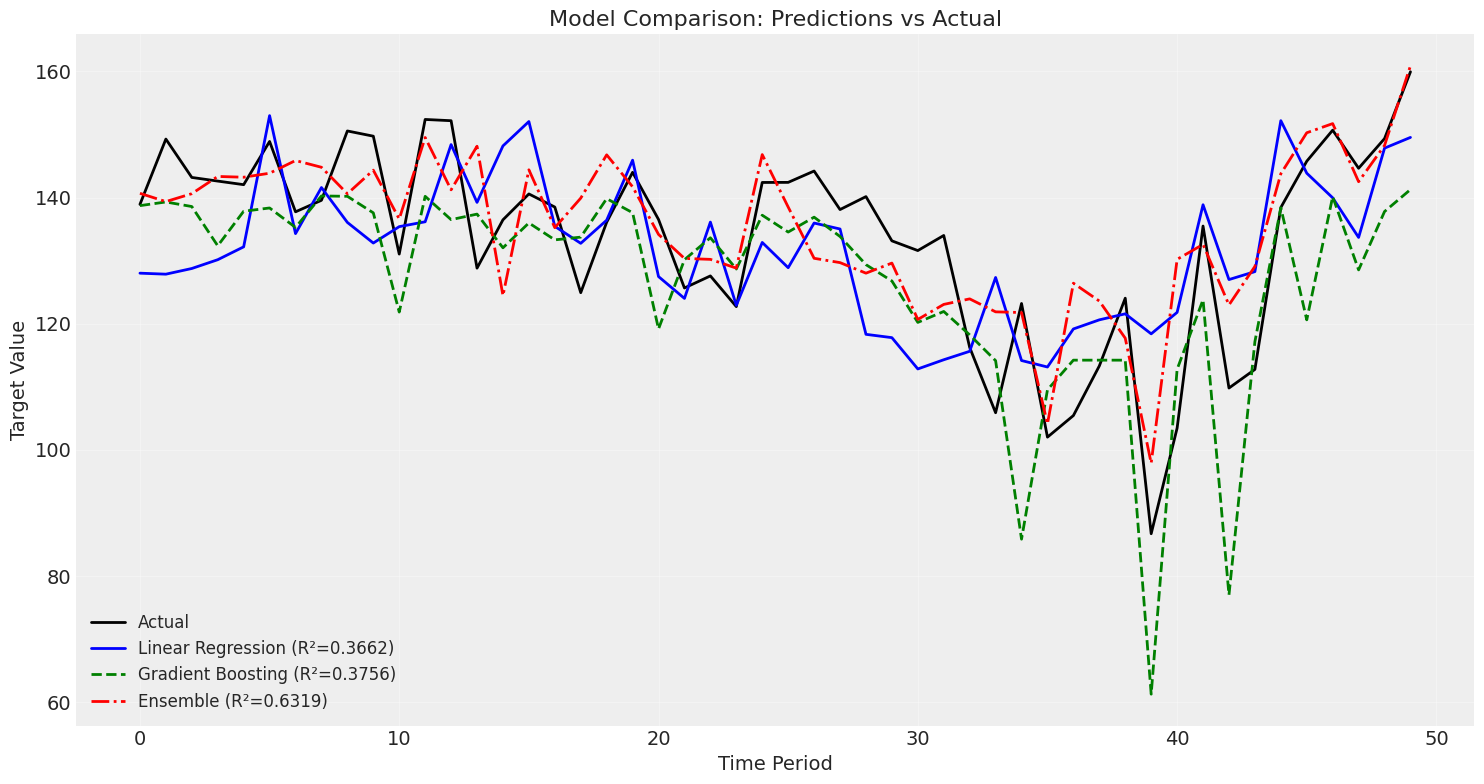


4. SHAP Analysis for the Ensemble model...
gb
  Using Ensemble for SHAP analysis (best R²)
  Plotting SHAP Feature Importance...


<Figure size 1500x800 with 0 Axes>

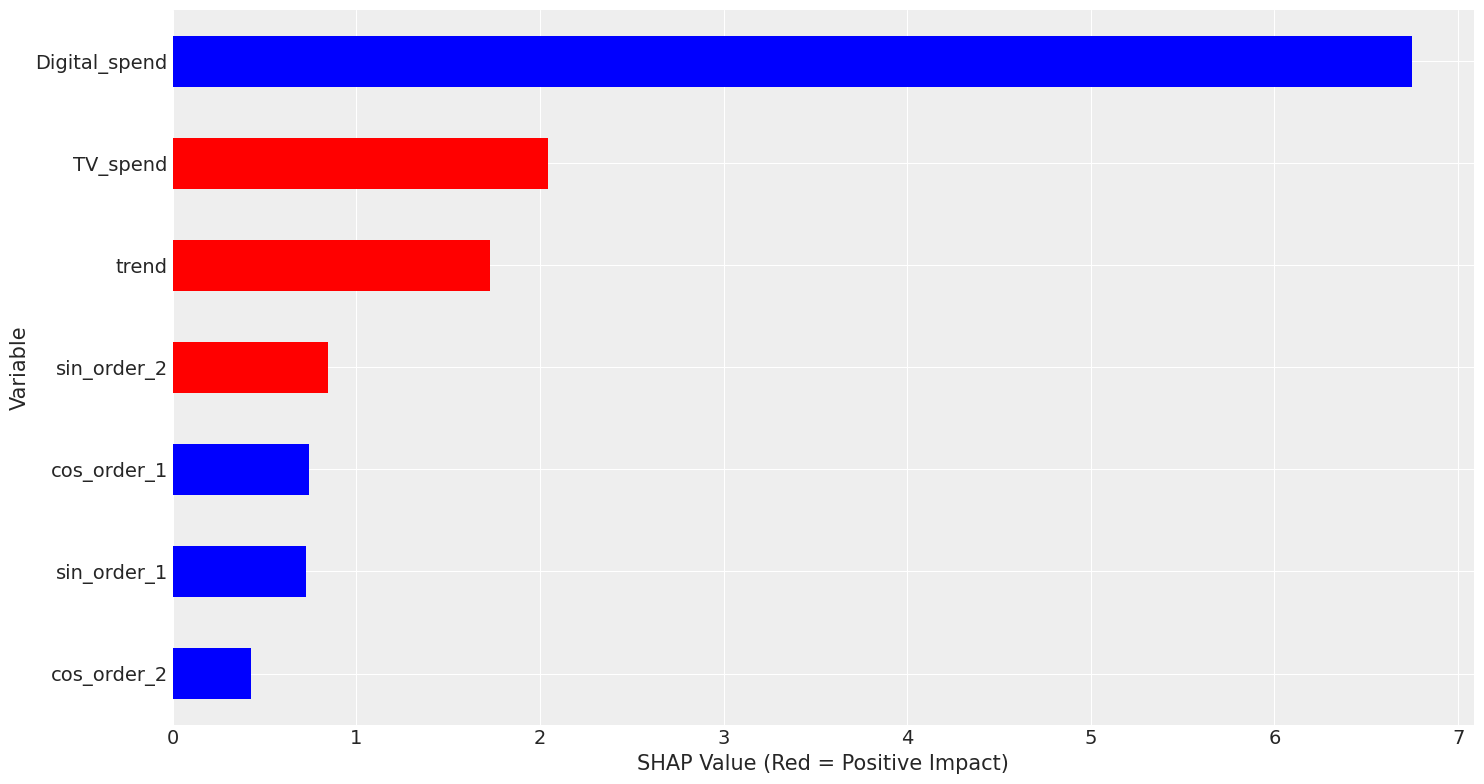


5. Spend vs Effect Analysis...
  RSSD Value: 0.0333 (lower is better)
  Spend vs Effect Share:
           media  effect_share  spend_share
0       TV_spend      0.232499     0.208924
1  Digital_spend      0.767501     0.791076
  Plotting Spend vs Effect Share...

6. SHAP vs Spend Analysis for Media Channels...


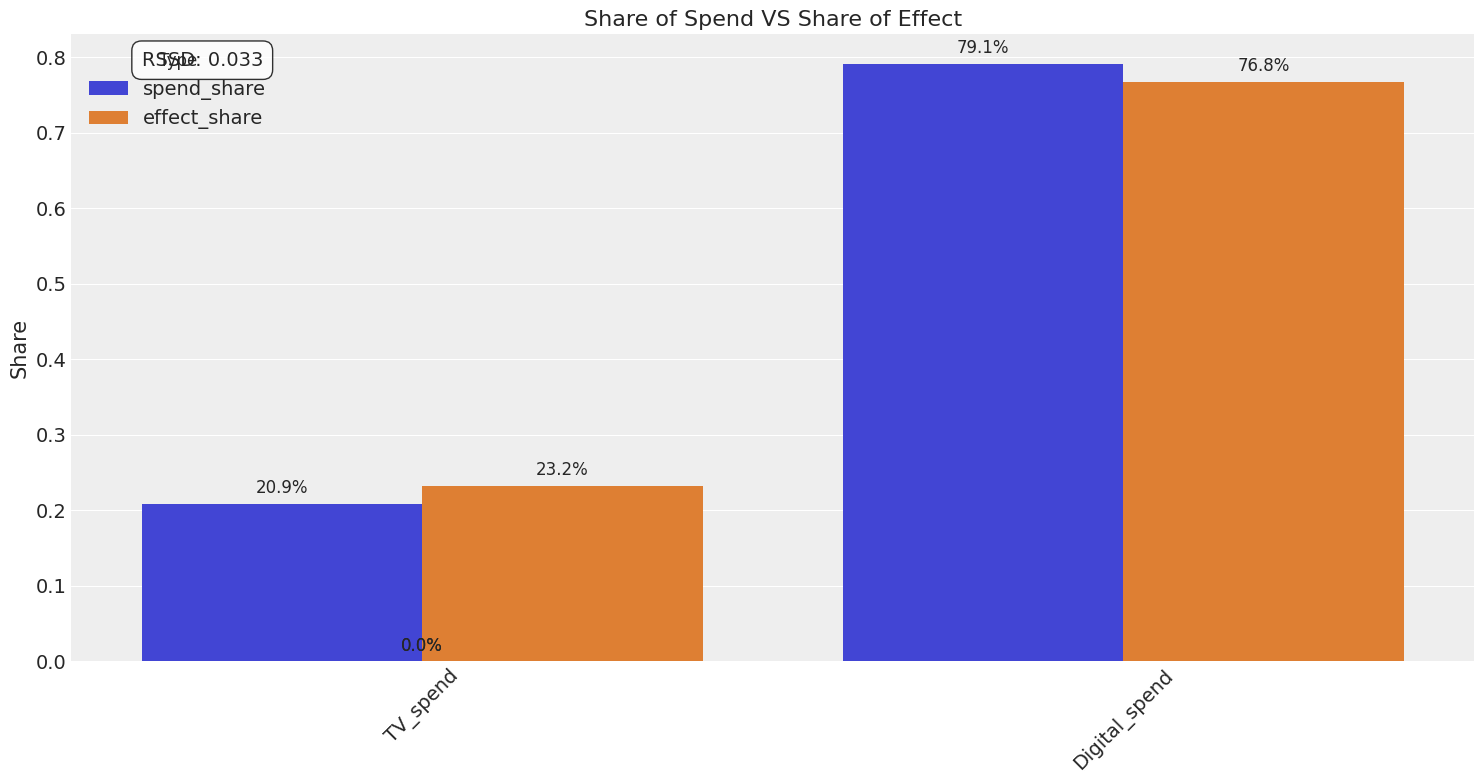

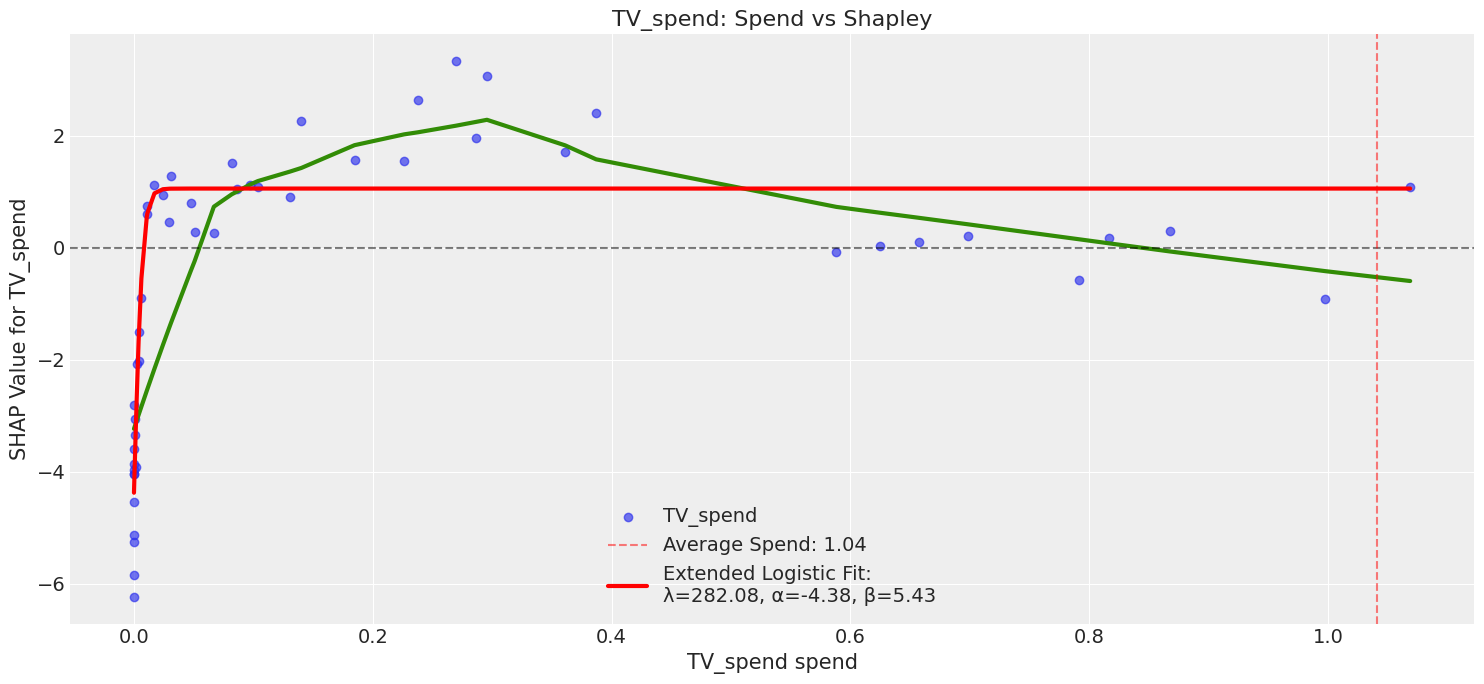

Logistic fit failed for Digital_spend: Optimal parameters not found: Number of calls to function has reached maxfev = 800.


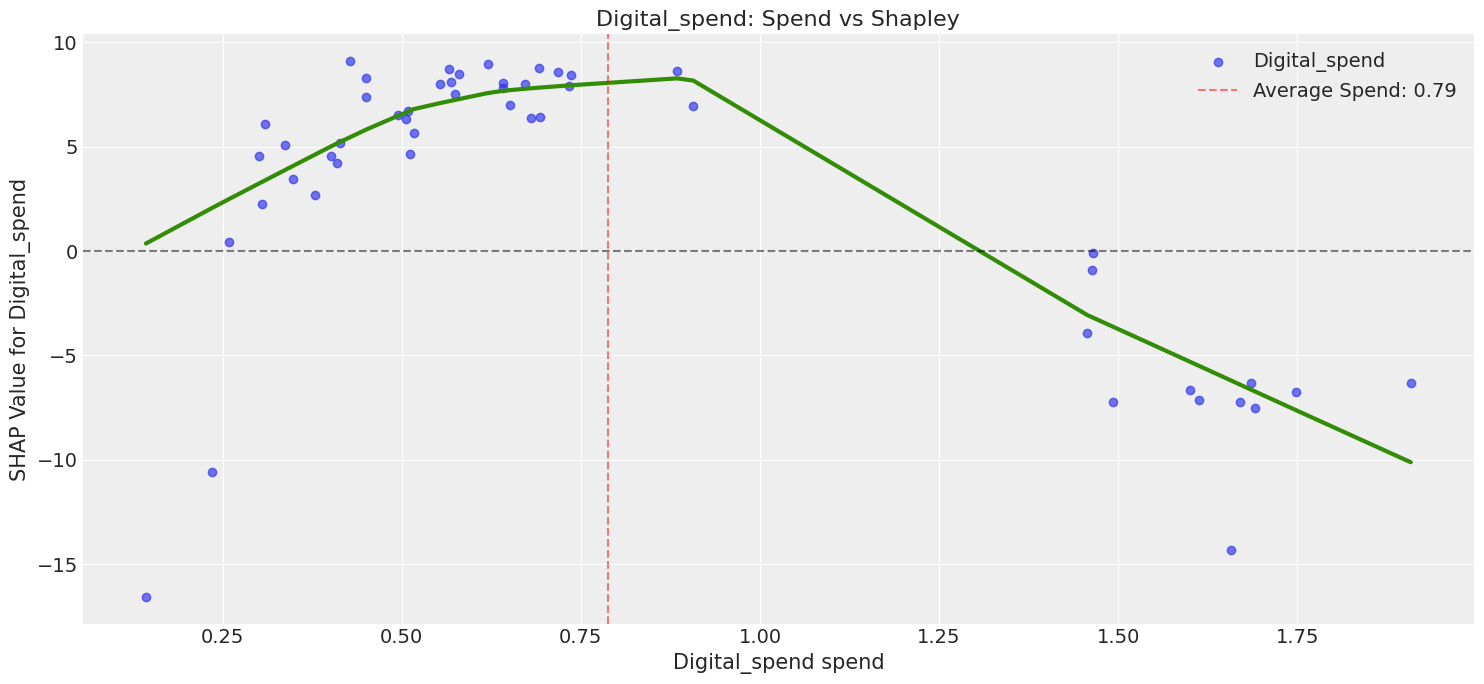


7. Comparing Adstock Parameters Across Models...
               Linear Regression  Gradient Boosting  Ensemble  True Value
TV_spend                0.347688           0.505905  0.362132         NaN
Digital_spend           0.308463           0.102543  0.192104         NaN
TV                           NaN                NaN       NaN    0.900000
Digital                      NaN                NaN       NaN    0.286293


<Figure size 1200x600 with 0 Axes>

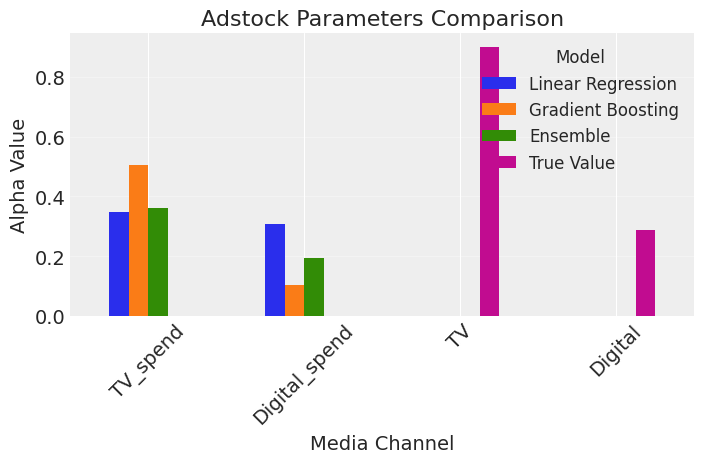


MMM Analysis Complete!


In [ ]:
# Your existing code for Fourier features
n_order = 2
periods = dataset.date.dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

# Create trend feature
trend = pd.DataFrame({"trend": np.arange(len(dataset.date))})

# Combine features
X = pd.concat([trend, spend_df, fourier_features], axis=1)
y = pd.Series(dataset.target.values.reshape(-1,), index=X.index)

# Define alpha ranges for media channels
alpha_ranges = {}
lambda_ranges = {}
for col in media_columns:
    if 'TV' in col.upper():
        alpha_ranges[col] = (0.3, 0.8)
        lambda_ranges[col] = (0,10)
    elif 'RADIO' in col.upper():
        alpha_ranges[col] = (0.1, 0.5)
    elif 'OOH' in col.upper():
        alpha_ranges[col] = (0.1, 0.4)
    elif 'DIGITAL' in col.upper() or 'SEARCH' in col.upper():
        alpha_ranges[col] = (0.0, 0.5)
        lambda_ranges[col] = (0,10)
    else:
        alpha_ranges[col] = (0.1, 0.7)

# Run the complete analysis
results = run_mmm_analysis(
    X=X,
    y=y,
    media_columns=media_columns,
    alpha_ranges=alpha_ranges,
    lambda_ranges=lambda_ranges,
    test_size=50,
    n_trials=1  # You might want to increase this for better results
)

## Bayesian model

### Data preparation

In [28]:
seed: int = 40
rng: np.random.Generator = np.random.default_rng(seed=seed)

#### Train test split

In [29]:
test_size = 50


t = (dataset.date - dataset.date.min()) / (dataset.date.max() - dataset.date.min())
t = t.values
t_train = t[None:-test_size]
t_test = t[-test_size:None]

In [30]:
dataset['target_scaled'] = xr.DataArray(
    np.zeros((len(dataset.date), len(countries))),
    coords={'date': dataset.date, 'country': countries},
    dims=['date', 'country']
)

dataset['z_scaled'] = xr.DataArray(
    np.zeros((len(dataset.date), len(channels), len(countries))),
    coords={'date': dataset.date, 'channel': channels, 'country': countries},
    dims=['date', 'channel', 'country']
)


# Instantiate scalers
target_scaler = MaxAbsScaler()
channel_scaler = MaxAbsScaler()

# Fit scalers
target = dataset.target.values.reshape(-1, 1)
spend = dataset.spends.values.reshape(-1, dataset.spends.shape[-1])

target_train = target[None:-test_size]
target_test = target[-test_size:None]


spend_train = spend[None:-test_size]
spend_test = spend[-test_size:None]

target_scaler.fit(target_train)
channel_scaler.fit(spend_train)


# Then apply scaling
for i, country in enumerate(countries):

    target_scaled = target_scaler.transform(target_train.reshape(-1,1)).flatten()
    target_test_scaled = target_scaler.transform(target_test.reshape(-1,1)).flatten()
    z_scaled = channel_scaler.transform(spend_train)
    z_test_scaled = channel_scaler.transform(spend_test)


In [31]:
channel_share_array = np.zeros((len(channels), len(countries)))

# Get
for i, country in enumerate(countries):
    y = dataset.target.sel(country=country)
    spends = dataset.spends.sel(country=country)

    # Calculate channel shares
    channel_share_array[:,i] = (spends.sum(axis=0) / spends.sum().sum())*len(channels)

## Model setup with pymc 

In [32]:
def geometric_adstock(x, alpha, l_max, normalize):
    """Vectorized geometric adstock transformation."""
    cycles = [
        pt.concatenate(tensor_list=[pt.zeros(shape=x.shape)[:i], x[: x.shape[0] - i]])
        for i in range(l_max)
    ]
    x_cycle = pt.stack(cycles)
    x_cycle = pt.transpose(x=x_cycle, axes=[1, 2, 0])
    w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])
    w = pt.transpose(w)[None, ...]
    w = w / pt.sum(w, axis=2, keepdims=True) if normalize else w
    return pt.sum(pt.mul(x_cycle, w), axis=2)


def logistic_saturation(x, lam):
    """Logistic saturation transformation."""
    return (1 - pt.exp(-lam * x)) / (1 + pt.exp(-lam * x))

Sampling: [a, alpha, b_fourier, b_trend, b_z, lam, likelihood, nu, sigma]


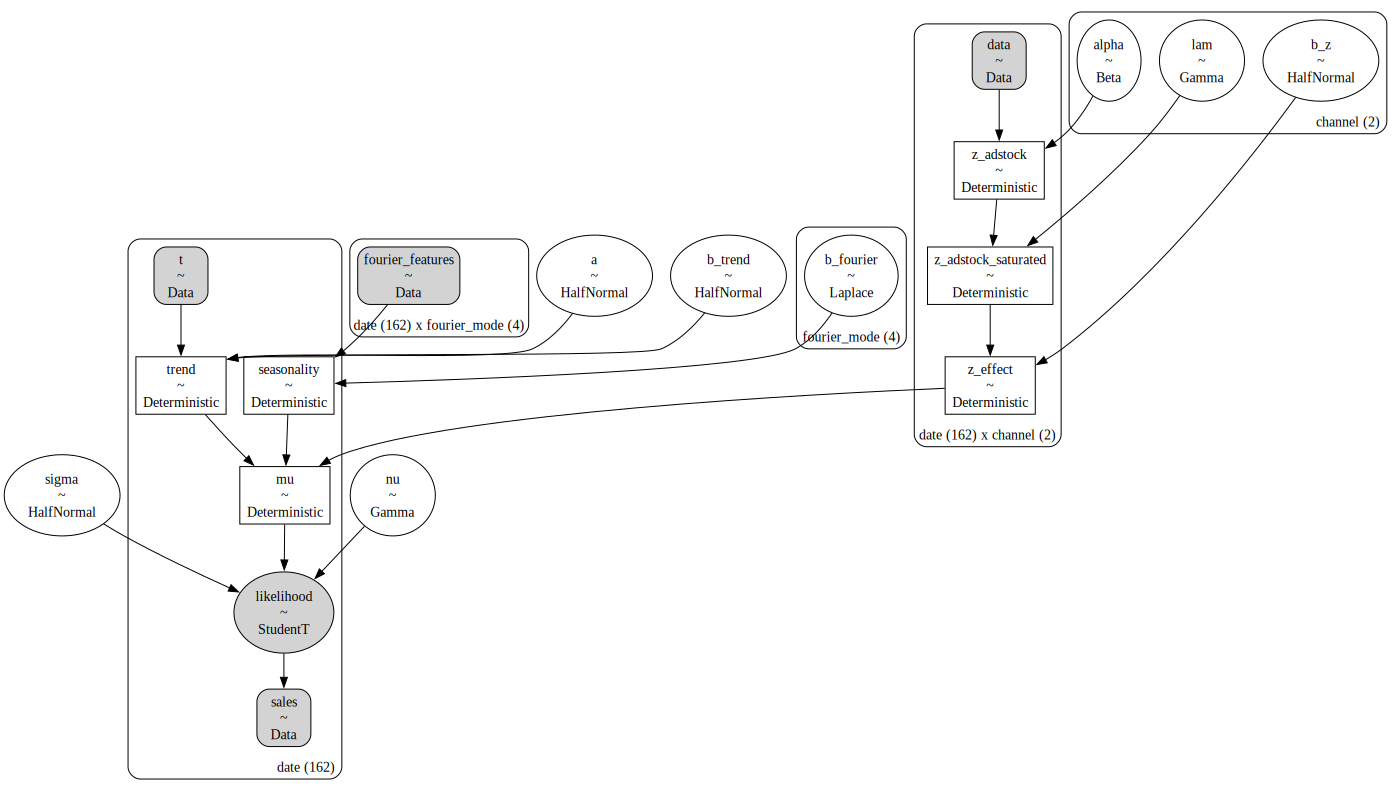

In [55]:




# Setup
n_order = 2
dates = dataset.date.values[None:-test_size]
coords = {"channel": channels, "fourier_mode": np.arange(2 * n_order)}


with pm.Model(coords=coords) as model:
    # --- coords --- #
    model.add_coord(name="date", values=dates)

    # --- data containers --- #
    data = pm.Data(
       "data",
       z_scaled,
       dims=("date", "channel"),
      # coords=dataset.date.values
    )

    fourier_feature_data = pm.Data(
        "fourier_features",
        fourier_features[None:-test_size],
        dims=("date", "fourier_mode")
    )

    t_data = pm.Data(
        "t",
        t_train,
        dims="date"
    )

    sales_data = pm.Data(
        "sales",
        target_scaled,
        dims="date"
    )

    # --- priors --- #
    ## intercept
    a = pm.HalfNormal(name="a", sigma=0.5)
    ## trend
    b_trend = pm.HalfNormal(name="b_trend", sigma=2)
    ## adstock effect
    alpha = pm.Beta(name="alpha", alpha=2, beta=2, dims="channel")
    ## saturation effect
    lam = pm.Gamma(name="lam", alpha=3, beta=1, dims="channel")
    ## seasonality
    b_fourier = pm.Laplace(name="b_fourier", mu=0, b=0.2, dims="fourier_mode")
    ## regressor
    b_z = pm.HalfNormal(name="b_z", sigma=channel_share_array.reshape(-1,1).flatten(), dims="channel")
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- model parametrization --- #
    trend = pm.Deterministic(name="trend", var=a + b_trend * t_data, dims="date")
    seasonality = pm.Deterministic(
        name="seasonality", var=pm.math.dot(fourier_feature_data, b_fourier), dims="date"
    )

    z_adstock = pm.Deterministic(
        name="z_adstock", var=geometric_adstock(x=data, alpha=alpha, l_max=8, normalize=True), dims=("date","channel")
    )

    z_adstock_saturated = pm.Deterministic(
        name="z_adstock_saturated",
        var=logistic_saturation(x=z_adstock, lam=lam),
        dims=("date","channel"),
    )
    z_effect = pm.Deterministic(
        name="z_effect", var=b_z * z_adstock_saturated, dims=("date","channel")
    )


    mu = pm.Deterministic(name="mu", var=trend + seasonality + z_effect.sum(axis=1), dims="date")

    # --- likelihood ---
    y = pm.StudentT(name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=sales_data, dims="date")


    # --- prior samples #
    adstock_saturation_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(model=model)

[Text(0.5, 1.0, 'Model - Prior Predictive Samples')]

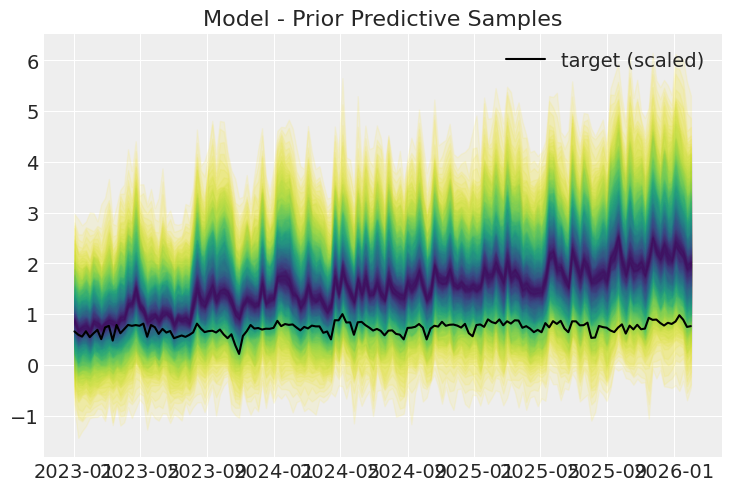

In [56]:
# useful way to color the distribution
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(adstock_saturation_model_prior_predictive.prior_predictive["likelihood"], p, axis=1)
    lower = np.percentile(
        adstock_saturation_model_prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=dates,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(x=dates, y=target_scaled, color="black", label="target (scaled)", ax=ax)
ax.legend()
ax.set(title="Model - Prior Predictive Samples")

In [57]:
with model:
    base_model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=2_000,
        target_accept=0.95,
        chains=4,
        idata_kwargs={"log_likelihood": True},
        random_seed=rng
    )
    base_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=base_model_trace,
        random_seed=rng,
        var_names=["likelihood"],

    )

    base_model_trace.extend(base_model_posterior_predictive)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

### Model summary 

In [58]:
az.summary(
    data=base_model_trace,
    var_names=["a", "b_trend", "b_z", "alpha", "lam", "sigma", "nu"],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a                0.078  0.044   0.001    0.151      0.001    0.001    3156.0   
b_trend          0.240  0.019   0.206    0.276      0.000    0.000    7257.0   
b_z[TV]          0.426  0.181   0.151    0.766      0.003    0.002    4060.0   
b_z[Digital]     0.536  0.044   0.458    0.615      0.001    0.001    3377.0   
alpha[TV]        0.866  0.034   0.801    0.928      0.000    0.000    7133.0   
alpha[Digital]   0.284  0.027   0.231    0.332      0.000    0.000    5836.0   
lam[TV]          2.581  1.172   0.716    4.655      0.018    0.012    4132.0   
lam[Digital]    14.869  0.960  12.998   16.616      0.014    0.010    4708.0   
sigma            0.045  0.003   0.040    0.051      0.000    0.000    7392.0   
nu              12.905  2.427   8.609   17.599      0.025    0.018    9277.0   

                ess_tail  r_hat  
a                 2639.0    1.0  
b_trend           6221.0    1.0  
b_z[TV]           5239.0    1.0  
b_z[Digital]      4300.0    1.0  
alpha[TV]         4579.0    1.0  
alpha[Digital]    5501.0    1.0  
lam[TV]           5295.0    1.0  
lam[Digital]      5874.0    1.0  
sigma             6026.0    1.0  
nu                5959.0    1.0

Text(0.5, 0.98, 'Base Model - Trace')

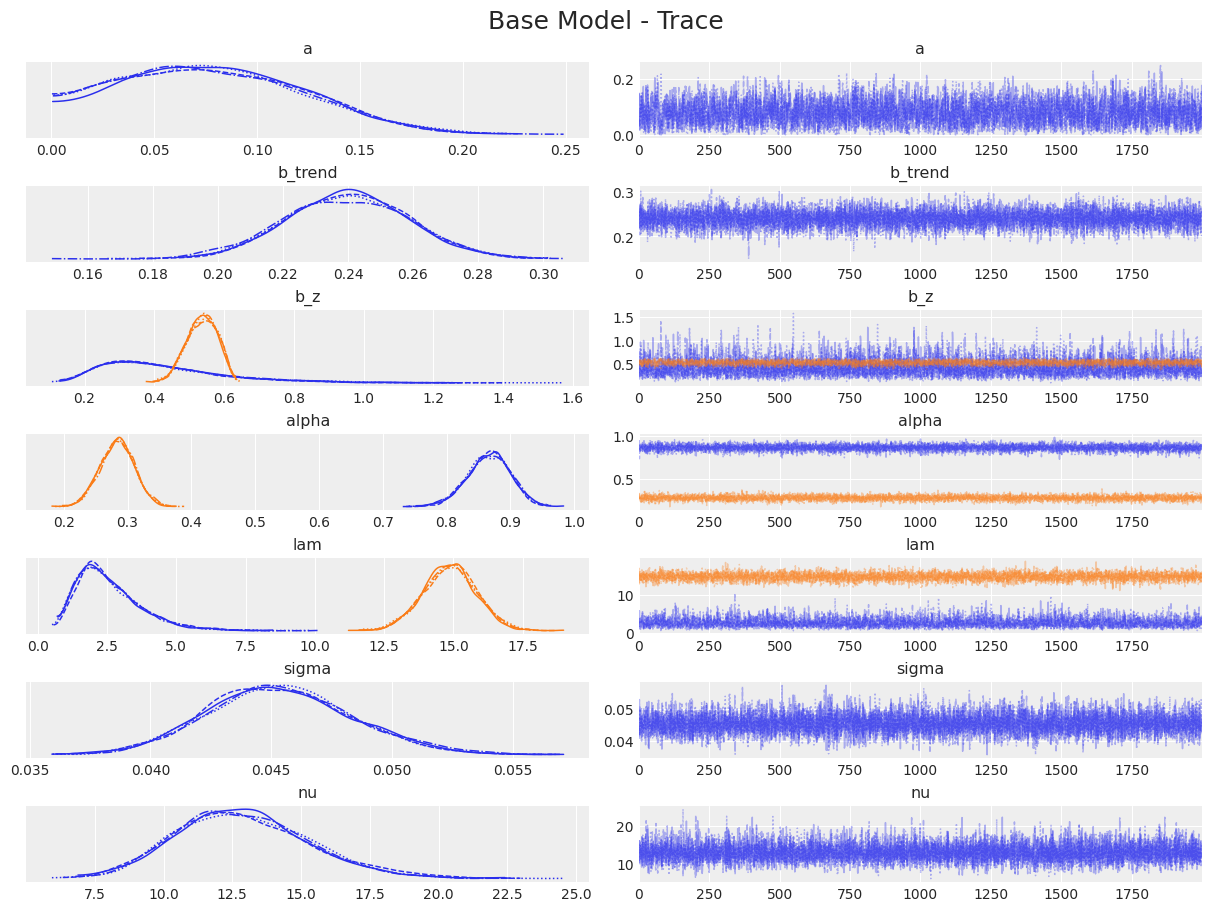

In [ ]:
axes = az.plot_trace(
    data=base_model_trace,
    var_names=["a", "b_trend", "b_z", "alpha", "lam", "sigma", "nu"],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace")

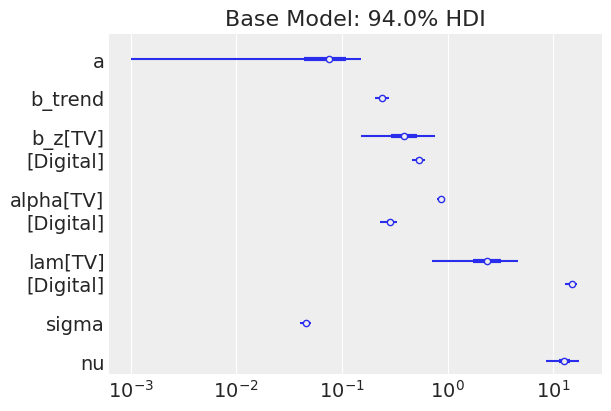

In [60]:
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(
    data=base_model_trace,
    var_names=["a", "b_trend", "b_z", "alpha", "lam", "sigma", "nu"],
    combined=True,
    ax=ax
)
ax.set(
    title="Base Model: 94.0% HDI",
    xscale="log"
);

### Posterior Predictive Sample

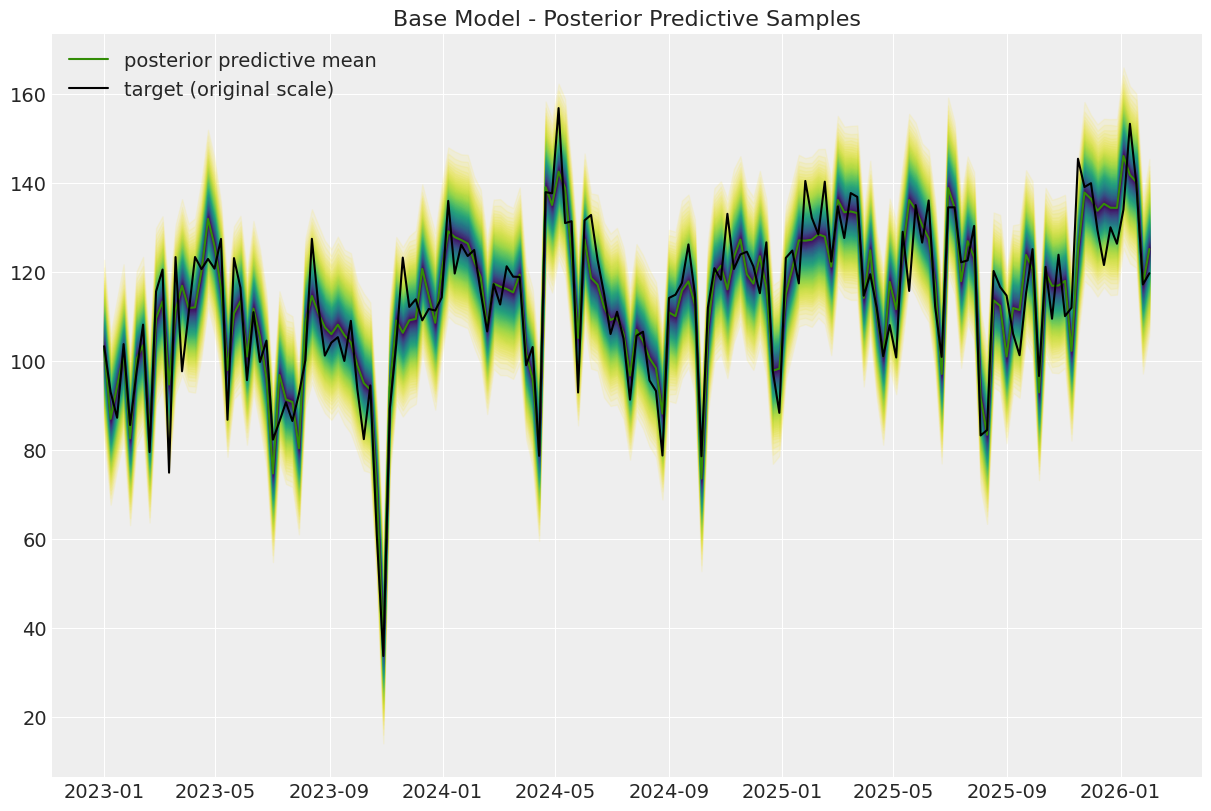

In [ ]:
posterior_predictive_likelihood = az.extract(
    data=base_model_posterior_predictive,
    group="posterior_predictive",
    var_names="likelihood",
)

posterior_predictive_likelihood_inv = target_scaler.inverse_transform(
    X=posterior_predictive_likelihood
)

fig, ax = plt.subplots(figsize=(12, 8))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=dates,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=dates,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=dates,
    y=target_train.flatten(),
    color="black",
    label="target (original scale)",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Base Model - Posterior Predictive Samples");

### Out of sample

In [ ]:
# First, update your model with the test data
with model:



    # Now update the data
    pm.set_data(new_data={"data": z_test_scaled,
                          "t": t_test,
                          "fourier_features": fourier_features[-test_size:None],
                          "sales": target_test_scaled,
                          }, coords={"date": dataset.date.values[-test_size:None]})



    base_model_trace.extend(
    # Generate posterior predictive samples
    other = pm.sample_posterior_predictive(
        trace=base_model_trace,
        predictions=True,
        var_names=["likelihood"],
        random_seed=rng,
        idata_kwargs={"coords": {"date": dataset.date.values[-test_size:None]}}
    ),
    # join="right",
    )


Sampling: [likelihood]


Output()

Available groups in base_model_trace: ['posterior', 'posterior_predictive', 'predictions', 'log_likelihood', 'sample_stats', 'observed_data', 'constant_data', 'predictions_constant_data']


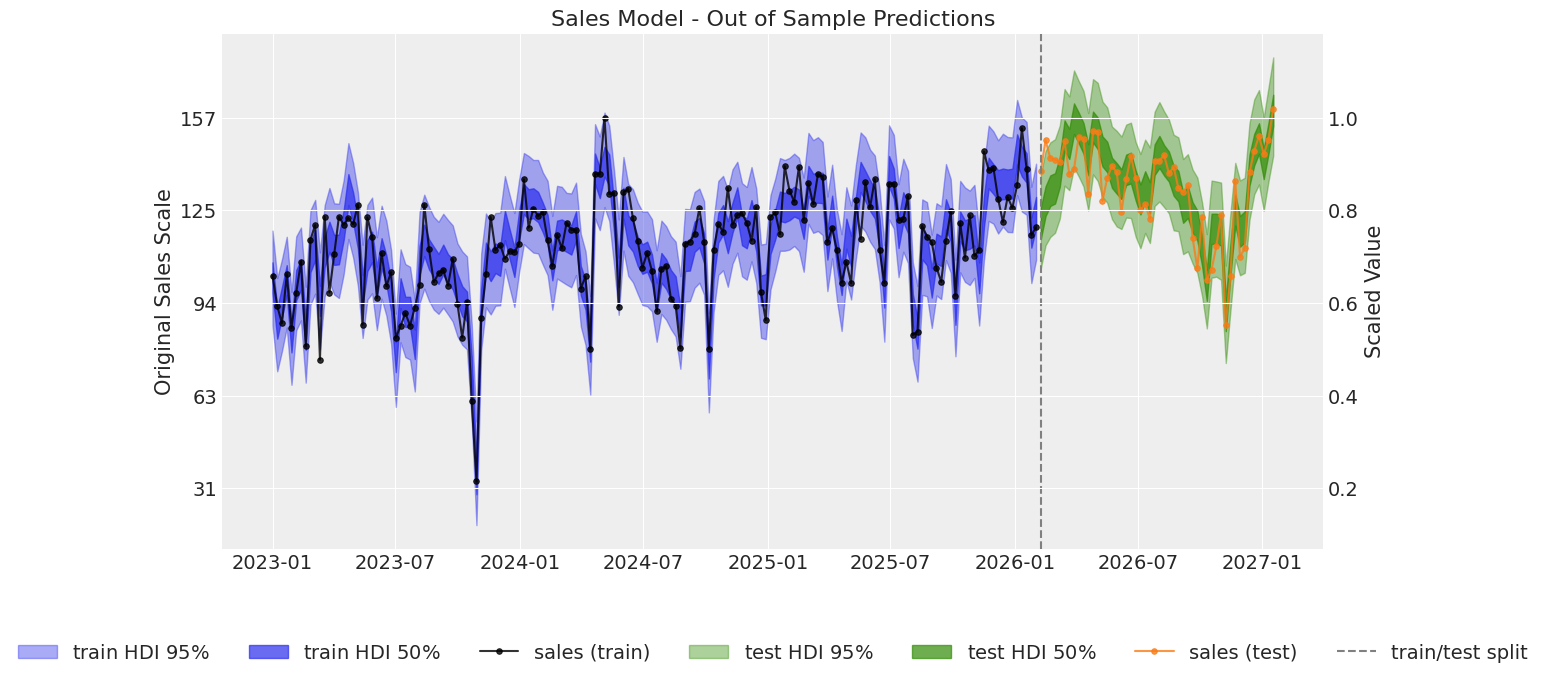

Test Metrics:
Scaled Space - MAE: 0.0376, RMSE: 0.0500
Original Space - MAE: 5.90, RMSE: 7.84, MAPE: 4.59%


In [ ]:


# Create a custom y-axis formatter to show original scale values
def scaled_to_original(y, pos):
    """Convert scaled y-values to original scale for display"""
    # Reshape y to match scaler expected format
    y_reshaped = np.array([[y]])
    # Convert to original scale
    y_original = target_scaler.inverse_transform(y_reshaped)[0, 0]
    return f'{y_original:.0f}'  # Format as needed

# Use your exact plot code but with base_model_trace instead of combined
fig, ax = plt.subplots(figsize=(15, 7))

# Plot training data predictions and HDI
az.plot_hdi(
    x=dates,
    y=base_model_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=0.95,
    color="C0",
    fill_kwargs={"alpha": 0.4, "label": r"train HDI $95\%$"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=dates,
    y=base_model_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=0.5,
    color="C0",
    fill_kwargs={"alpha": 0.7, "label": r"train HDI $50\%$"},
    smooth=False,
    ax=ax,
)
sns.lineplot(
    x=dates,
    y=target_scaled,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
    ax=ax,
)

# Extract test predictions from base_model_trace instead of combined_posterior_predictive
test_dates = dataset.date.values[-test_size:]

# Check which groups are available in base_model_trace
available_groups = list(base_model_trace.groups())
print(f"Available groups in base_model_trace: {available_groups}")

if 'predictions' in available_groups:
    # Use posterior_predictive from base_model_trace if available
    az.plot_hdi(
        x=test_dates,
        y=base_model_trace["predictions"]["likelihood"],
        hdi_prob=0.95,
        color="C2",
        fill_kwargs={"alpha": 0.4, "label": r"test HDI $95\%$"},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x=test_dates,
        y=base_model_trace["predictions"]["likelihood"],
        hdi_prob=0.5,
        color="C2",
        fill_kwargs={"alpha": 0.7, "label": r"test HDI $50\%$"},
        smooth=False,
        ax=ax,
    )

    # Calculate test prediction mean for metrics
    test_pred_mean = base_model_trace["predictions"]["likelihood"].mean(dim=["chain", "draw"]).values
else:
    print("Warning: 'predictions' not found in base_model_trace.")
    test_pred_mean = None

sns.lineplot(
    x=test_dates,
    y=target_test_scaled,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="sales (test)",
    ax=ax,

)

# Optional: Add a vertical line at the train/test split
train_test_date = dataset.date.values[-test_size]
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")

# Apply the formatter to show original scale on y-axis
ax.yaxis.set_major_formatter(FuncFormatter(scaled_to_original))

# Add a secondary y-axis showing the scaled values
ax_scaled = ax.twinx()
ax_scaled.set_ylim(ax.get_ylim())
ax_scaled.set_ylabel('Scaled Value')
ax_scaled.spines['right'].set_visible(True)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=7)
ax.set(title="Sales Model - Out of Sample Predictions")
ax.set_ylabel("Original Sales Scale")
plt.tight_layout()
plt.show()

# Display metrics if test predictions are available
if test_pred_mean is not None and target_test_scaled is not None:
    # Calculate metrics in scaled space
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    mae_scaled = mean_absolute_error(target_test_scaled, test_pred_mean)
    rmse_scaled = np.sqrt(mean_squared_error(target_test_scaled, test_pred_mean))

    # Calculate metrics in original scale
    test_pred_mean_orig = target_scaler.inverse_transform(test_pred_mean.reshape(-1, 1)).flatten()
    target_test_orig = target_scaler.inverse_transform(target_test_scaled.reshape(-1, 1)).flatten()

    mae_orig = mean_absolute_error(target_test_orig, test_pred_mean_orig)
    rmse_orig = np.sqrt(mean_squared_error(target_test_orig, test_pred_mean_orig))
    mape = np.mean(np.abs((target_test_orig - test_pred_mean_orig) / target_test_orig)) * 100

    print(f"Test Metrics:")
    print(f"Scaled Space - MAE: {mae_scaled:.4f}, RMSE: {rmse_scaled:.4f}")
    print(f"Original Space - MAE: {mae_orig:.2f}, RMSE: {rmse_orig:.2f}, MAPE: {mape:.2f}%")

Seems really good except around the train test split... 
What's the reason of this? 
Refer to the carryover effect ;)  

### Adding the carryover effect to your test set

In [67]:
l_max = 8  # This should match your adstock's l_max parameter

# Combine last l_max training observations with test data
z_combined = np.vstack([z_scaled[-l_max:], z_test_scaled])

# Combine the dates as well
combined_dates = np.concatenate([dataset.date.values[-l_max-test_size:-test_size],
                               dataset.date.values[-test_size:]])

# combined_index_scaled = np.concatenate([index_train_scaled[-l_max:None],
#                                index_test_scaled])


# Combined t values
t_combined = np.concatenate([t_train[-l_max:], t_test])

# Combined fourier features
fourier_combined = np.vstack([fourier_features[-l_max-test_size:-test_size],
                            fourier_features[-test_size:]])

if target_test_scaled is not None:
    target_combined = np.concatenate([target_scaled[-l_max:], target_test_scaled])
else:
    target_combined = np.concatenate([target_scaled[-l_max:],
                                     np.full(test_size, np.nan)])

# Update model with the combined data
with model:
    pm.set_data(
        new_data={
            "data": z_combined,
            "t": t_combined,
           #  "index_scaled_data": combined_index_scaled,
            "fourier_features": fourier_combined
        },
        coords={"date": combined_dates}
    )

    # Generate posterior predictive samples
    combined_posterior_predictive = pm.sample_posterior_predictive(
        trace=base_model_trace,
        var_names=["likelihood"],
        random_seed=rng,
        predictions=True,
        idata_kwargs={"coords": {"date": combined_dates}}
    )

Sampling: [likelihood]


Output()

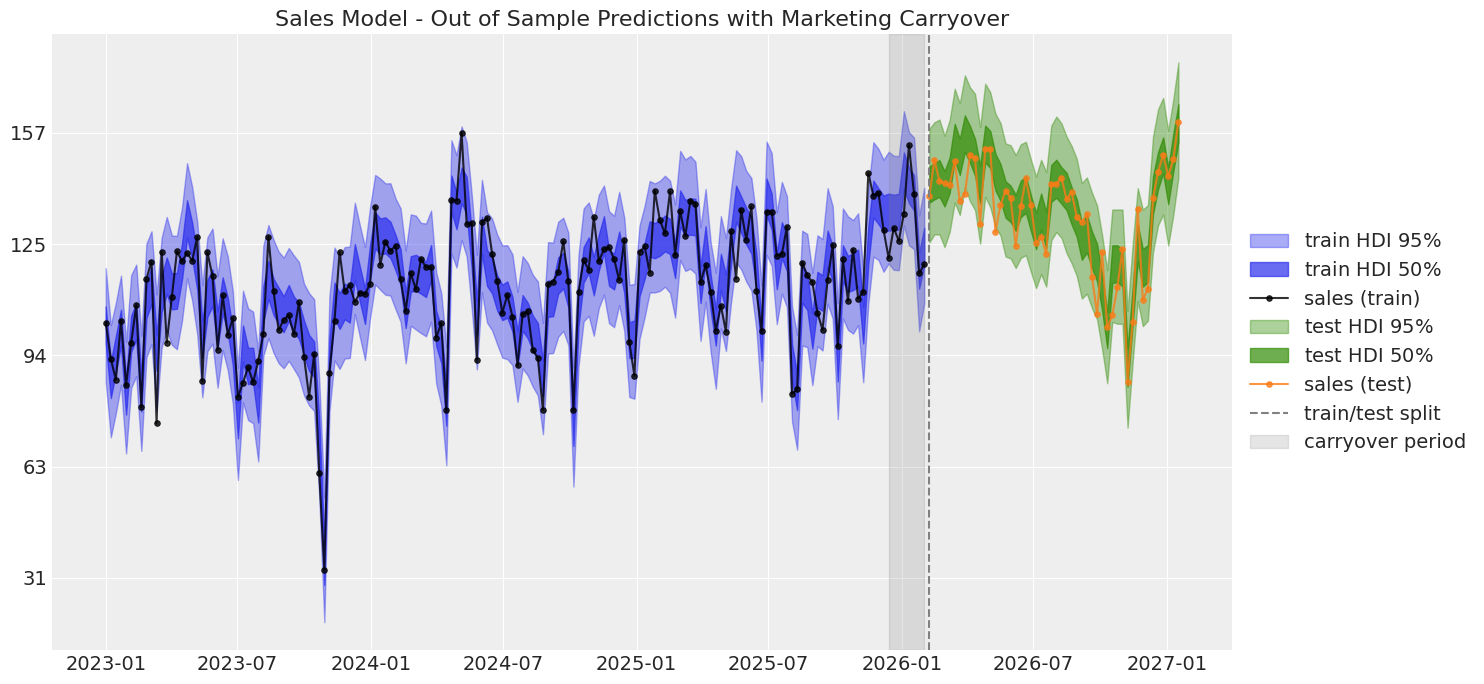

Test Metrics (with carryover effects):
Scaled Space - MAE: 0.0321, RMSE: 0.0427
Original Space - MAE: 5.03, RMSE: 6.70, MAPE: 3.99%


In [69]:
from matplotlib.ticker import FuncFormatter


def scaled_to_original(y, pos):
    """Convert scaled y-values to original scale for display"""
    # Reshape y to match scaler expected format
    y_reshaped = np.array([[y]])
    # Convert to original scale
    y_original = target_scaler.inverse_transform(y_reshaped)[0, 0]
    return f'{y_original:.0f}'  # Format as needed

# Create the plot with exactly the same layout
fig, ax = plt.subplots(figsize=(15, 7))

# Plot training data predictions and HDI
az.plot_hdi(
    x=dates,
    y=base_model_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=0.95,
    color="C0",
    fill_kwargs={"alpha": 0.4, "label": r"train HDI $95\%$"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=dates,
    y=base_model_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=0.5,
    color="C0",
    fill_kwargs={"alpha": 0.7, "label": r"train HDI $50\%$"},
    smooth=False,
    ax=ax,
)
sns.lineplot(
    x=dates,
    y=target_scaled,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
    ax=ax,
)

# Extract only the test part (skip carryover observations)
test_dates = dataset.date.values[-test_size:]
test_predictions = combined_posterior_predictive["predictions"]["likelihood"].isel(date=slice(l_max, None))

az.plot_hdi(
    x=test_dates,
    y=test_predictions,
    hdi_prob=0.95,
    color="C2",
    fill_kwargs={"alpha": 0.4, "label": r"test HDI $95\%$"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=test_dates,
    y=test_predictions,
    hdi_prob=0.5,
    color="C2",
    fill_kwargs={"alpha": 0.7, "label": r"test HDI $50\%$"},
    smooth=False,
    ax=ax,
)
sns.lineplot(
    x=test_dates,
    y=target_test_scaled,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="sales (test)",
    ax=ax,
)

# Optional: Add a vertical line at the train/test split
train_test_date = dataset.date.values[-test_size]
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")

# Optional: To show carryover period explicitly
carryover_dates = dataset.date.values[-l_max-test_size:-test_size]
ax.axvspan(carryover_dates[0], carryover_dates[-1], alpha=0.2, color='gray', label='carryover period')

# Apply the formatter to show original scale on y-axis
ax.yaxis.set_major_formatter(FuncFormatter(scaled_to_original))

# Add a secondary y-axis showing the scaled values
#ax_scaled = ax.twinx()
#ax_scaled.set_ylim(ax.get_ylim())
#ax_scaled.set_ylabel('Scaled Value')
#ax_scaled.spines['right'].set_visible(True)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Sales Model - Out of Sample Predictions with Marketing Carryover")

plt.tight_layout()
plt.show()

# Display metrics if you have test data
if target_test_scaled is not None:
    # Calculate predictions mean
    test_pred_mean = test_predictions.mean(dim=["chain", "draw"]).values

    # Calculate metrics in scaled space
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    mae_scaled = mean_absolute_error(target_test_scaled, test_pred_mean)
    rmse_scaled = np.sqrt(mean_squared_error(target_test_scaled, test_pred_mean))

    # Calculate metrics in original scale
    test_pred_mean_orig = target_scaler.inverse_transform(test_pred_mean.reshape(-1, 1)).flatten()
    target_test_orig = target_scaler.inverse_transform(target_test_scaled.reshape(-1, 1)).flatten()

    mae_orig = mean_absolute_error(target_test_orig, test_pred_mean_orig)
    rmse_orig = np.sqrt(mean_squared_error(target_test_orig, test_pred_mean_orig))
    mape = np.mean(np.abs((target_test_orig - test_pred_mean_orig) / target_test_orig)) * 100

    print(f"Test Metrics (with carryover effects):")
    print(f"Scaled Space - MAE: {mae_scaled:.4f}, RMSE: {rmse_scaled:.4f}")
    print(f"Original Space - MAE: {mae_orig:.2f}, RMSE: {rmse_orig:.2f}, MAPE: {mape:.2f}%")

### Model parameters 

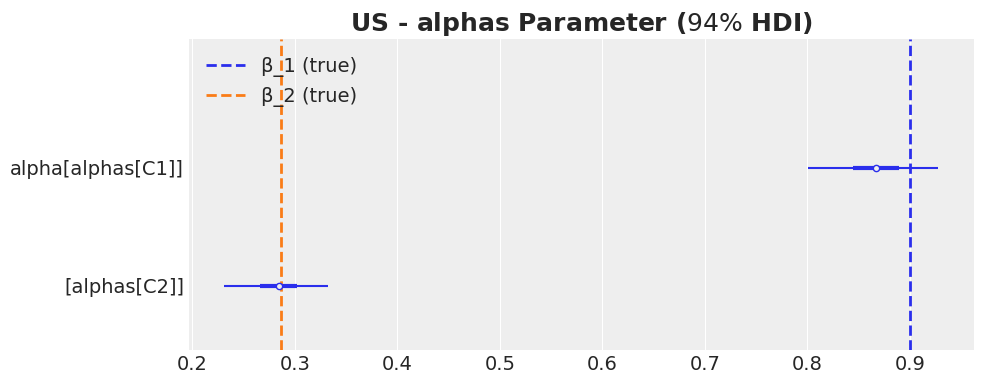

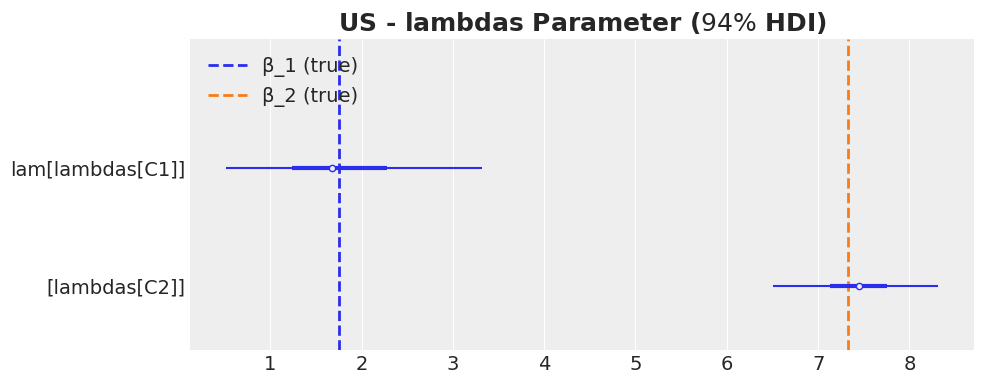

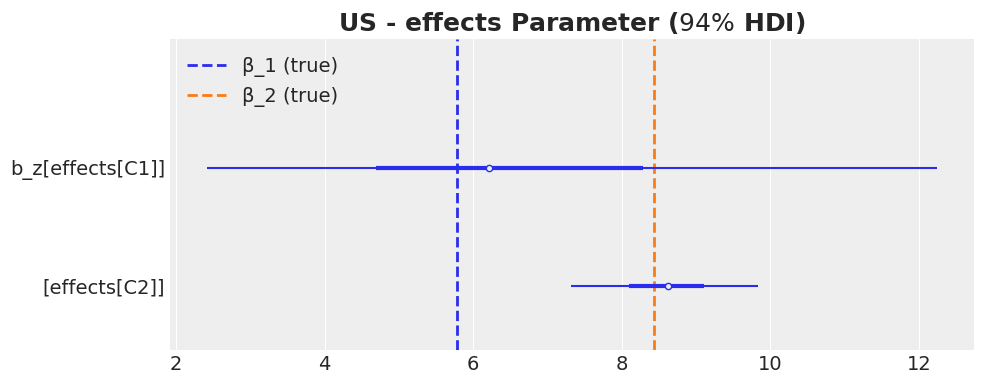

In [70]:
# Initialize single scalers for all countries
channel_scaler = MaxAbsScaler()
target_scaler = MaxAbsScaler()

# Fit scalers on all data
all_spends = dataset.spends.values.reshape(-1, len(channels))  # Flatten across countries and dates
all_targets = dataset.target.values.reshape(-1, 1)  # Flatten across countries and dates

channel_scaler.fit(all_spends)
target_scaler.fit(all_targets)

# Now recover parameters using these global scalers
recovered_params = {}
for country in countries:
    # Scale posteriors using the global scalers
    alphas = base_model_trace.posterior["alpha"]
    lams = base_model_trace.posterior["lam"] / channel_scaler.scale_
    betas = (base_model_trace.posterior["b_z"] *
             target_scaler.scale_) / 10  # Divide by amplitude

    recovered_params[country] = {
        'alphas': alphas,
        'lambdas': lams,
        'effects': betas
    }

# Plot function remains the same
def plot_param_comparison(param_name, recovered_params, country_params, countries, channels):
    fig, axes = plt.subplots(len(countries), 1, figsize=(10, 4*len(countries)))

    for i, country in enumerate(countries):
        ax = axes[i] if len(countries) > 1 else axes
        data = recovered_params[country][param_name]
        param_data = []
        param_names = []

        for j, channel in enumerate(channels):
            param_data.append(data[:,:,j])
            param_names.append(f"{param_name}[C{j+1}]")
            true_val = country_params[country][param_name][channel]
            ax.axvline(true_val, color=f"C{j}", linestyle="--", linewidth=2,
                      label=f"β_{j+1} (true)")

        combined_data = xr.concat(param_data, dim='channel')
        combined_data = combined_data.assign_coords(channel=param_names)

        az.plot_forest(data=combined_data, combined=True, hdi_prob=0.94, ax=ax)
        ax.legend(loc="upper left")
        ax.set_title(label=f"{country} - {param_name} Parameter ($94\\%$ HDI)",
                    fontsize=18, fontweight="bold")

    plt.tight_layout()

# Plot each parameter
for param in ['alphas', 'lambdas', 'effects']:
    plot_param_comparison(param, recovered_params, country_params, countries, channels)

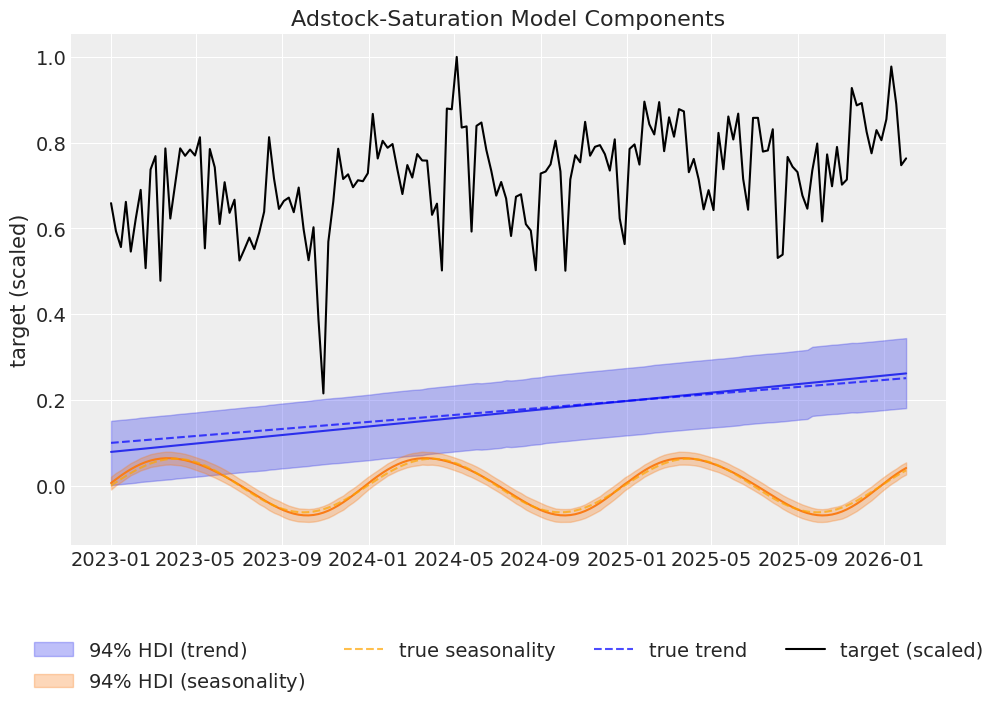

In [71]:
# compute HDI for all the model parameters
model_hdi = az.hdi(ary=base_model_trace)

fig, ax = plt.subplots(figsize=(10,7))

for i, var_effect in enumerate(["trend", "seasonality"]):
    ax.fill_between(
        x=dates,
        y1=model_hdi[var_effect][:, 0],
        y2=model_hdi[var_effect][:, 1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI ({var_effect})",
    )
    sns.lineplot(
        x=dates,
        y=base_model_trace.posterior[var_effect]
        .stack(sample=("chain", "draw"))
        .mean(axis=1),
        color=f"C{i}",
    )

true_seasonality = target_scaler.transform(
    dataset.seasonality.sel(country=country)[:-test_size].values.reshape(-1, 1)*10
).flatten()

# Plot the true seasonality
sns.lineplot(
    x=dates,
    y=true_seasonality,  # Now properly flattened to 1D
    color="orange",
    alpha=0.7,
    linestyle="--",
    label="true seasonality",
    ax=ax
)


true_trend_and_intercept = target_scaler.transform(
    dataset.trend.sel(country=country)[:-test_size].values.reshape(-1, 1)*10
).flatten() + target_scaler.transform(
    dataset.base_sales.sel(country=country)[:-test_size].values.reshape(-1, 1)*10
).flatten()

# Plot the true trend
sns.lineplot(
    x=dates,
    y=true_trend_and_intercept,  # Now properly flattened to 1D
    color="blue",
    alpha=0.7,
    linestyle="--",
    label="true trend",
    ax=ax
)

sns.lineplot(
    x=dates, y=target_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax
)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)



ax.set(
    title="Adstock-Saturation Model Components",
    ylabel="target (scaled)",
);

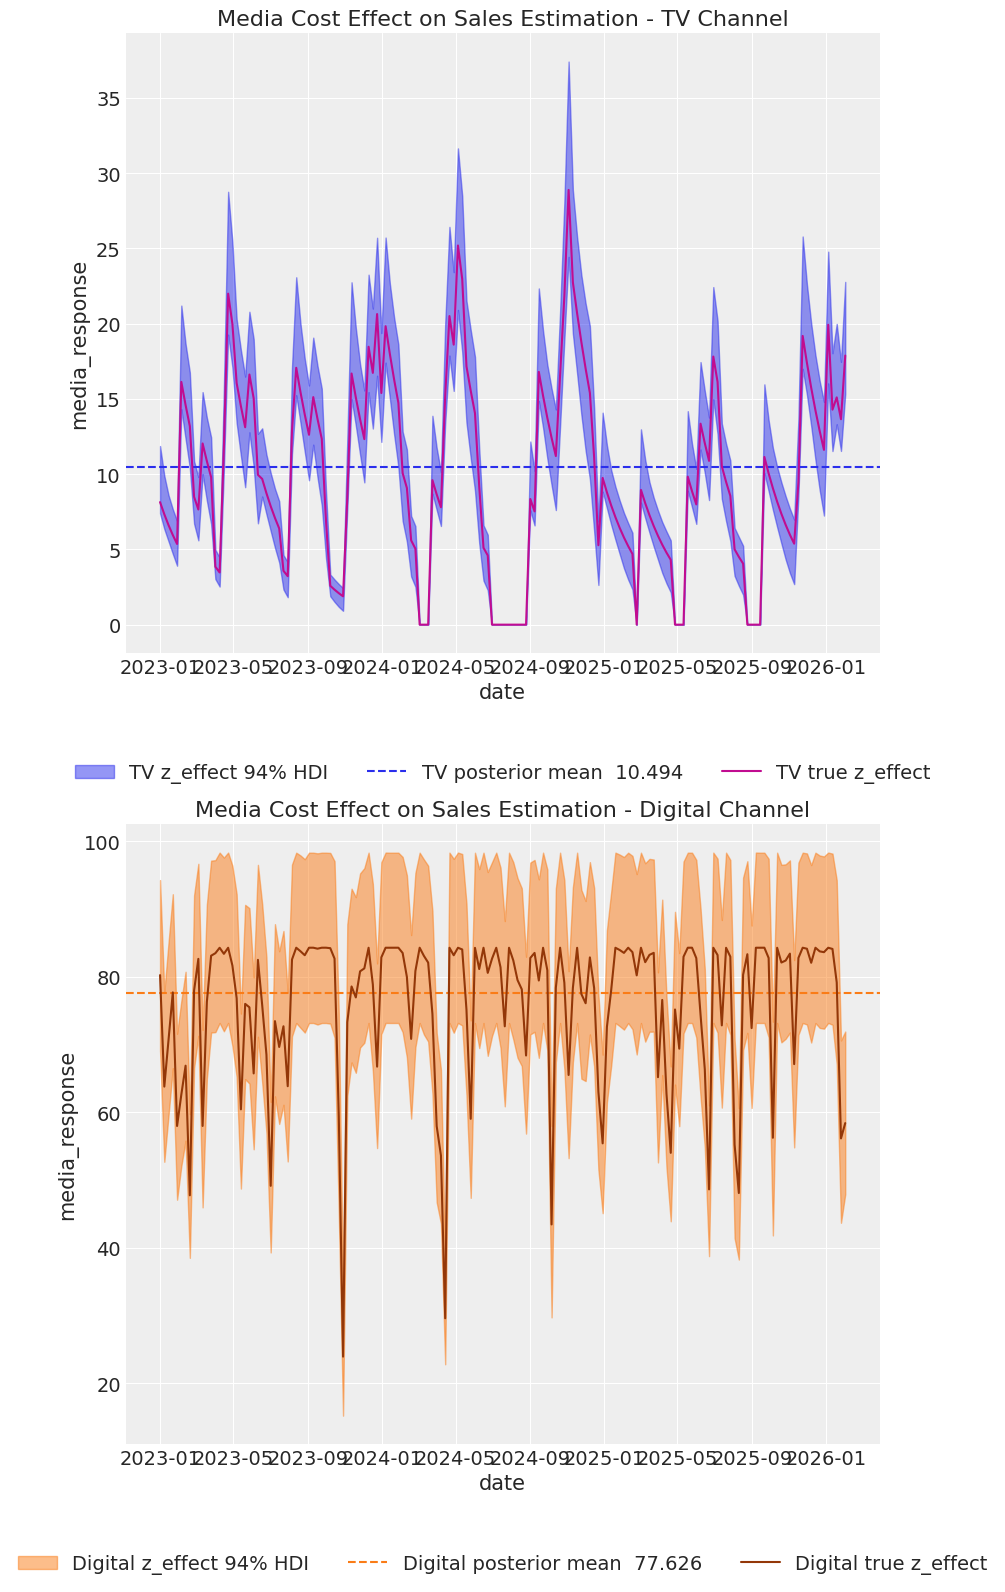

In [ ]:
# For multiple channels, we need to handle each channel separately
z_effect_posterior_samples = []

# Loop through each channel
for channel_idx in range(base_model_trace.posterior["z_effect"].sizes["channel"]):
    # Extract data for this channel
    channel_data = base_model_trace.posterior["z_effect"].isel(channel=channel_idx)

    # Apply transformation for this channel
    channel_samples = xr.apply_ufunc(
        lambda x: target_scaler.inverse_transform(X=x.reshape(1, -1)),
        channel_data,
        input_core_dims=[["date"]],
        output_core_dims=[["date"]],
        vectorize=True,
    )

    z_effect_posterior_samples.append(channel_samples)

# Combine the results back into a single DataArray with channel dimension
z_effect_posterior_samples = xr.concat(z_effect_posterior_samples, dim="channel")

# Calculate HDI as before
z_effect_hdi = az.hdi(ary=z_effect_posterior_samples)["z_effect"]

# Plot for each channel
fig, axes = plt.subplots(nrows=len(dataset.channel), figsize=(10, 8*len(dataset.channel)))
if len(dataset.channel) == 1:
    axes = [axes]  # Make it iterable if there's only one subplot

for i, (ax, channel) in enumerate(zip(axes, dataset.channel.values)):
    ax.fill_between(
        x=dataset.date[:-test_size],
        y1=z_effect_hdi.sel(channel=channel)[:, 0],
        y2=z_effect_hdi.sel(channel=channel)[:, 1],
        color=f"C{i}",
        alpha=0.5,
        label=f"{channel} z_effect 94% HDI",
    )
    ax.axhline(
        y=z_effect_posterior_samples.sel(channel=channel).mean(),
        color=f"C{i}",
        linestyle="--",
        label=f"{channel} posterior mean {z_effect_posterior_samples.sel(channel=channel).mean().values: 0.3f}",
    )

    # Plot the original data for this channel
    sns.lineplot(
        x="date",
        y="media_response",
        color=f"C{i+3}",
        data=(dataset.media_response.sel(channel=channel)*10).to_dataframe().reset_index()[:-test_size],
        label=f"{channel} true z_effect",
        ax=ax
    )

    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=7)
    ax.set(title=f"Media Cost Effect on Sales Estimation - {channel} Channel")

plt.tight_layout()

Perfect! The model succeeded in capturing the true trend, seasonality and media parameters!

# Adding a non linear pattern 

## Let's reuse our data generation class

In [73]:
dataset, global_params, country_params, dynamics_dict = generator.generate_dataset_with_dynamics(n_dates=n_dates,
    countries=countries,
    channels=channels,
    apply_dynamic_effects=True
    )

## Visualization

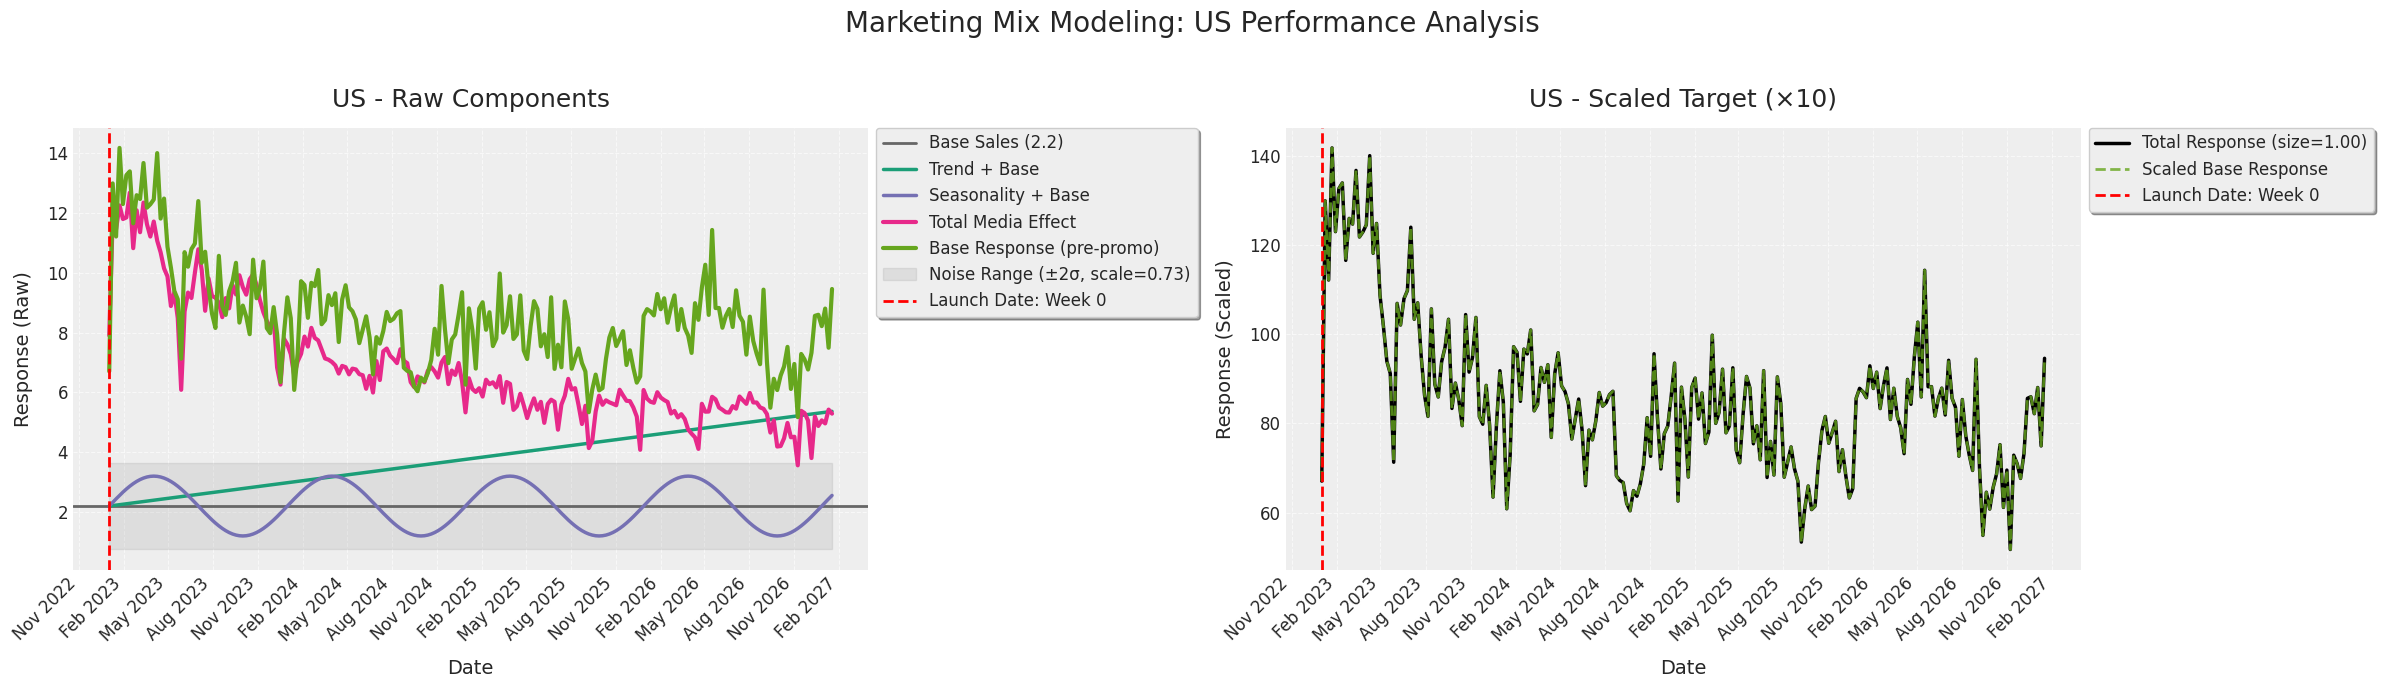

In [ ]:
visualizer = MMMVisualizer()
country_subset = ['US']  # Focus on one country for clarity
# Example 2: Focus on base components and total media only
components_basic = {
    'base_sales': True,
    'trend': True,
    'seasonality': True,
    'individual_channels': False,
    'total_media': True,
    'base_response': True,
    'noise_line': False,
    'noise_range': True,
    'target': True,
    'scaled_base': True,
    'promo_effects': False
}
fig = visualizer.plot_contributions(dataset, country_params, country_subset, components_basic)

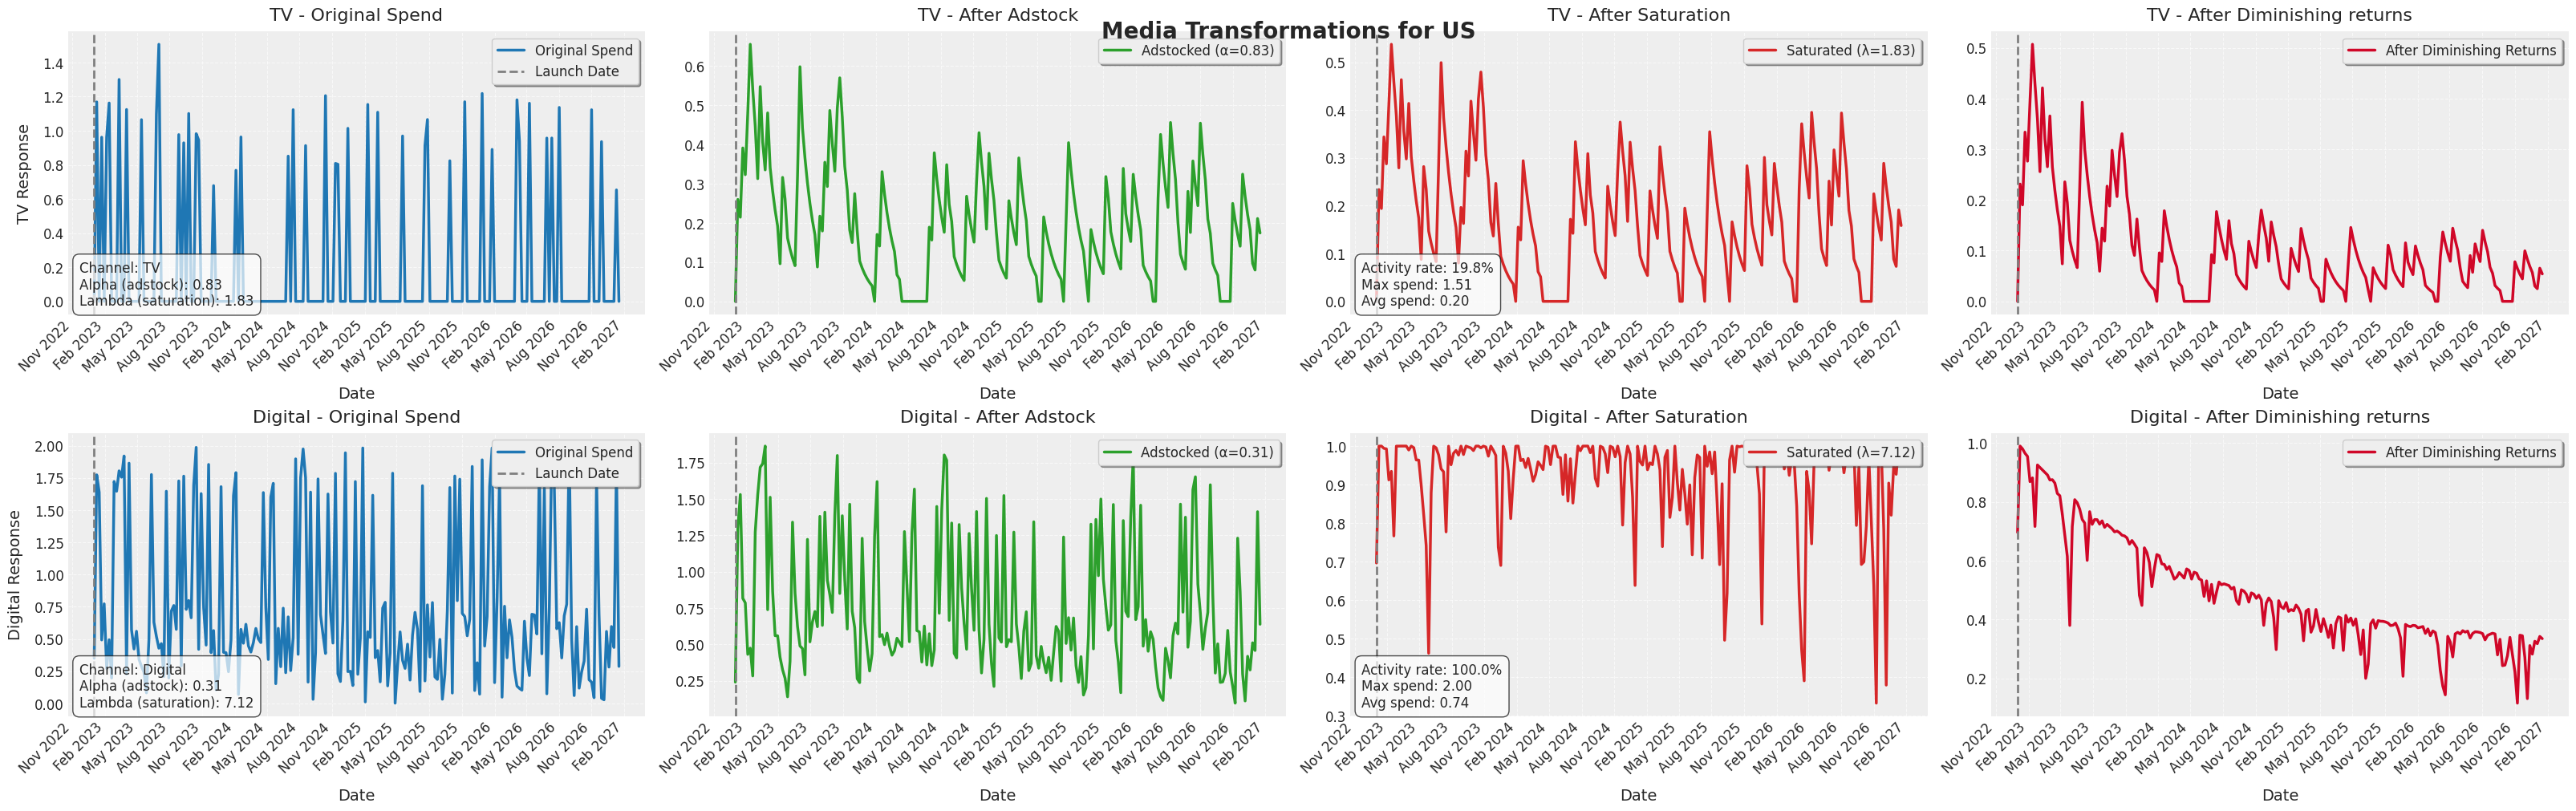

In [75]:
fig_2 = visualizer.plot_media_transformations(dataset, country_params, countries, dynamics_dict=dynamics_dict)

## Compare performance from traditional models

[I 2025-03-12 11:06:17,966] A new study created in memory with name: no-name-a7240784-2837-45bb-8005-c4d5fabf46bc


Starting MMM Analysis...

1. Training models for comparison...
  Training Linear Regression model...


[I 2025-03-12 11:06:39,438] Trial 0 finished with value: 12.83809691153316 and parameters: {'alpha_TV_spend': 0.6210772346355335, 'alpha_Digital_spend': 0.3017373792282578, 'linear_alpha': 0.04865028704004632}. Best is trial 0 with value: 12.83809691153316.
[I 2025-03-12 11:06:48,473] Trial 1 finished with value: 12.402161515667153 and parameters: {'alpha_TV_spend': 0.7731084609480412, 'alpha_Digital_spend': 0.38994209614392333, 'linear_alpha': 1.5319042743258018}. Best is trial 1 with value: 12.402161515667153.
[I 2025-03-12 11:06:56,324] Trial 2 finished with value: 13.53937032554862 and parameters: {'alpha_TV_spend': 0.592296679143044, 'alpha_Digital_spend': 0.06626735810763917, 'linear_alpha': 0.7044311160589622}. Best is trial 1 with value: 12.402161515667153.
[I 2025-03-12 11:07:06,327] Trial 3 finished with value: 12.58290709372395 and parameters: {'alpha_TV_spend': 0.6765145814911309, 'alpha_Digital_spend': 0.28487588469643677, 'linear_alpha': 0.2985257454290961}. Best is trial

  Training Gradient Boosting model...


[I 2025-03-12 11:14:33,715] Trial 0 finished with value: 16.230941380064788 and parameters: {'alpha_TV_spend': 0.6084675347375499, 'alpha_Digital_spend': 0.12575018221975248, 'learning_rate': 0.10994174252489582, 'n_estimators': 77, 'max_depth': 5}. Best is trial 0 with value: 16.230941380064788.
[I 2025-03-12 11:14:49,224] Trial 1 finished with value: 17.134779921636355 and parameters: {'alpha_TV_spend': 0.3530696661547708, 'alpha_Digital_spend': 0.2783091177132555, 'learning_rate': 0.053154368223399154, 'n_estimators': 140, 'max_depth': 4}. Best is trial 0 with value: 16.230941380064788.
[I 2025-03-12 11:15:06,191] Trial 2 finished with value: 15.279040538797304 and parameters: {'alpha_TV_spend': 0.6772386284482282, 'alpha_Digital_spend': 0.09002437913536004, 'learning_rate': 0.012661978789188628, 'n_estimators': 141, 'max_depth': 4}. Best is trial 2 with value: 15.279040538797304.
[I 2025-03-12 11:15:19,101] Trial 3 finished with value: 15.719083766067948 and parameters: {'alpha_TV_

  Training Ensemble model...


[I 2025-03-12 11:23:46,662] Trial 0 finished with value: 13.999163290962546 and parameters: {'alpha_TV_spend': 0.6615191998273531, 'alpha_Digital_spend': 0.12617429665593505, 'linear_alpha': 7.104423957882236, 'learning_rate': 0.026387005202823756, 'n_estimators': 120, 'max_depth': 2}. Best is trial 0 with value: 13.999163290962546.
[I 2025-03-12 11:23:59,390] Trial 1 finished with value: 15.37404211675538 and parameters: {'alpha_TV_spend': 0.6043868014929337, 'alpha_Digital_spend': 0.15587719656612592, 'linear_alpha': 1.8761735261011545, 'learning_rate': 0.057781428003359545, 'n_estimators': 80, 'max_depth': 5}. Best is trial 0 with value: 13.999163290962546.
[I 2025-03-12 11:24:15,038] Trial 2 finished with value: 14.907232798439244 and parameters: {'alpha_TV_spend': 0.32250707095734665, 'alpha_Digital_spend': 0.02615968765534804, 'linear_alpha': 0.489710518241144, 'learning_rate': 0.016895720005721804, 'n_estimators': 61, 'max_depth': 3}. Best is trial 0 with value: 13.9991632909625


2. Evaluating models...
  Linear Regression Results:
    RMSE:  11.86
    R²:    0.0150
    MAPE:  0.1267
    NRMSE: 0.1895
  Gradient Boosting Results:
    RMSE:  10.71
    R²:    0.1964
    MAPE:  0.1094
    NRMSE: 0.1712
  Ensemble Results:
    RMSE:  11.90
    R²:    0.0085
    MAPE:  0.1248
    NRMSE: 0.1902

3. Plotting predictions vs actual...


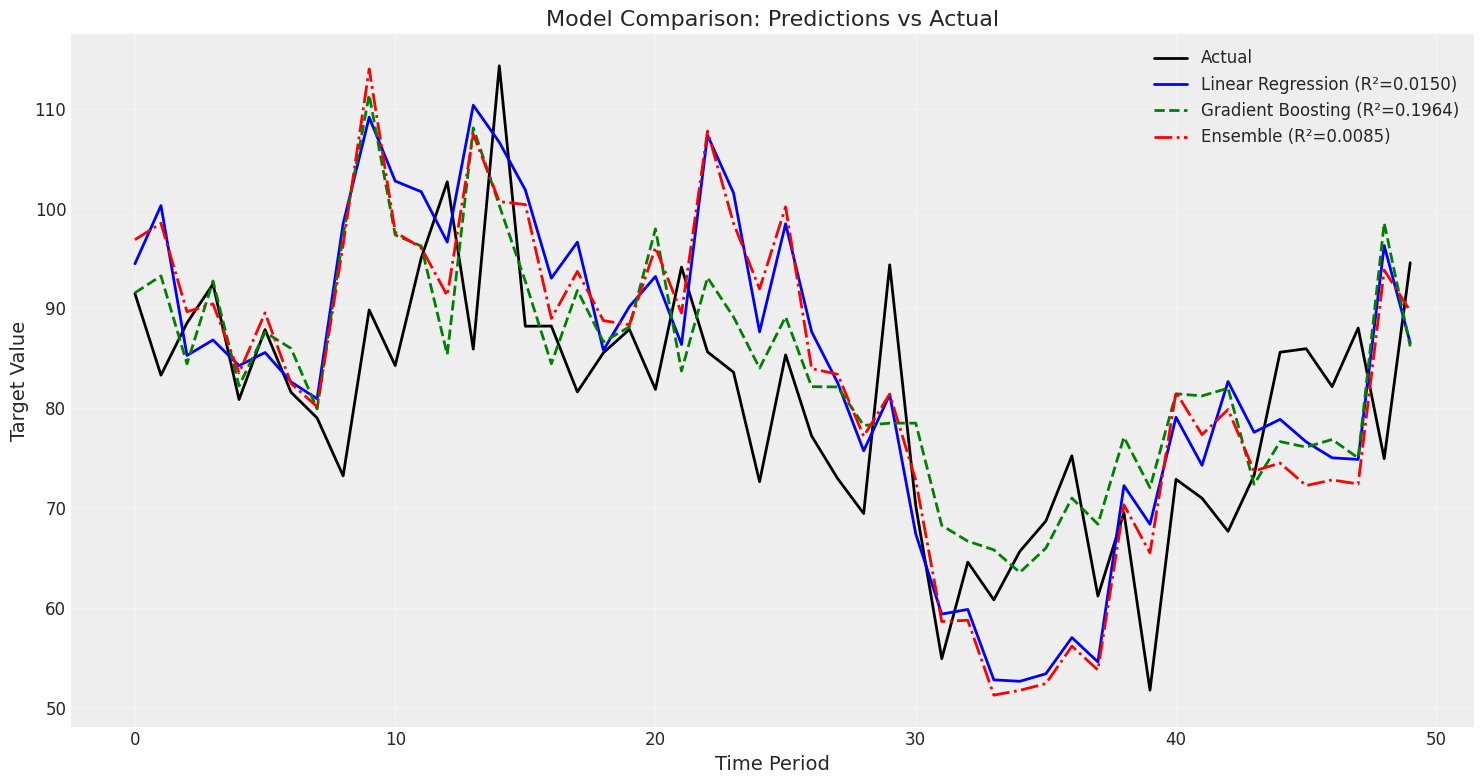


4. SHAP Analysis for the Ensemble model...
gb
  Using Gradient Boosting for SHAP analysis (best R²)
  Plotting SHAP Feature Importance...


/Users/damien/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


<Figure size 1500x800 with 0 Axes>

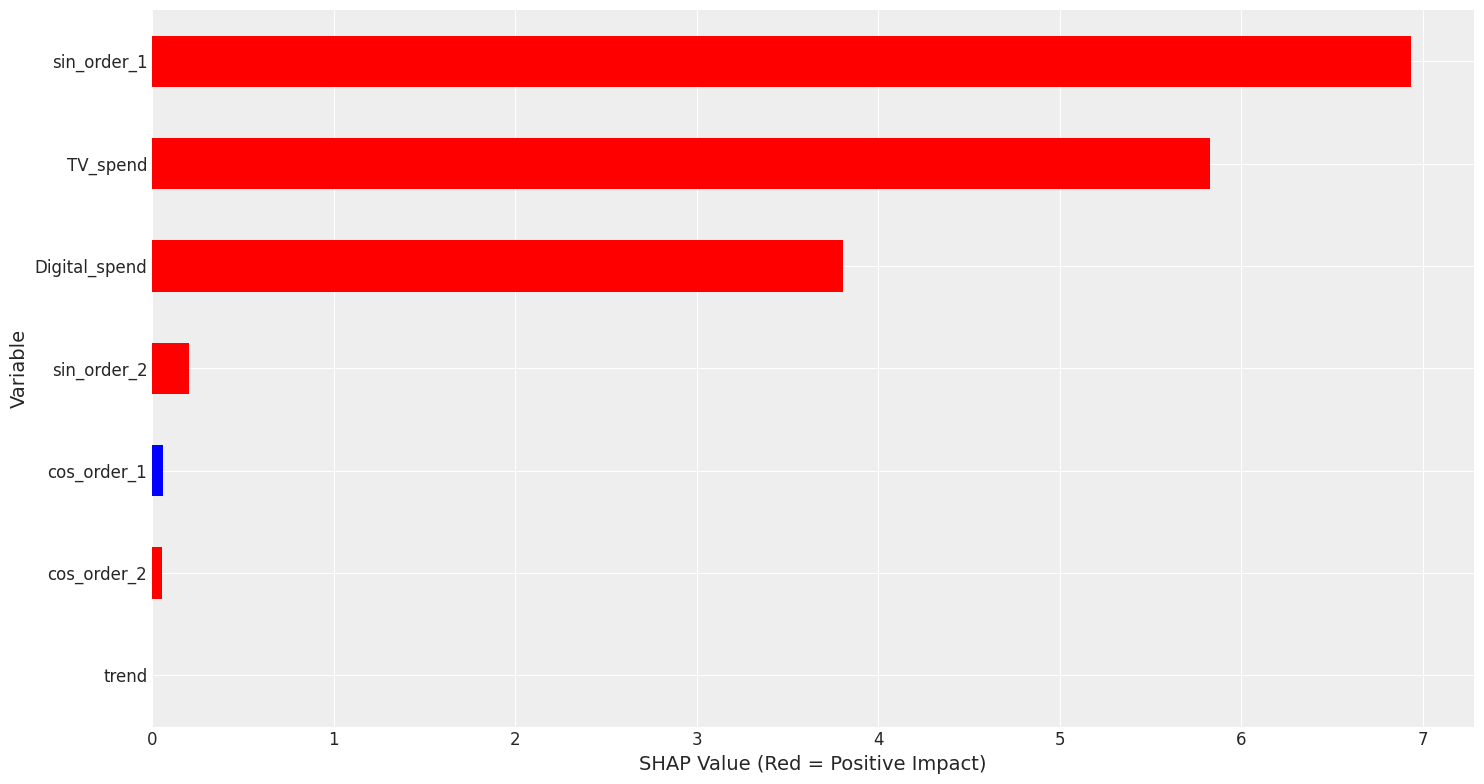


5. Spend vs Effect Analysis...
  RSSD Value: 0.5403 (lower is better)
  Spend vs Effect Share:
           media  effect_share  spend_share
0       TV_spend      0.604915     0.222857
1  Digital_spend      0.395085     0.777143
  Plotting Spend vs Effect Share...

6. SHAP vs Spend Analysis for Media Channels...
Logistic fit failed for TV_spend: Optimal parameters not found: Number of calls to function has reached maxfev = 800.


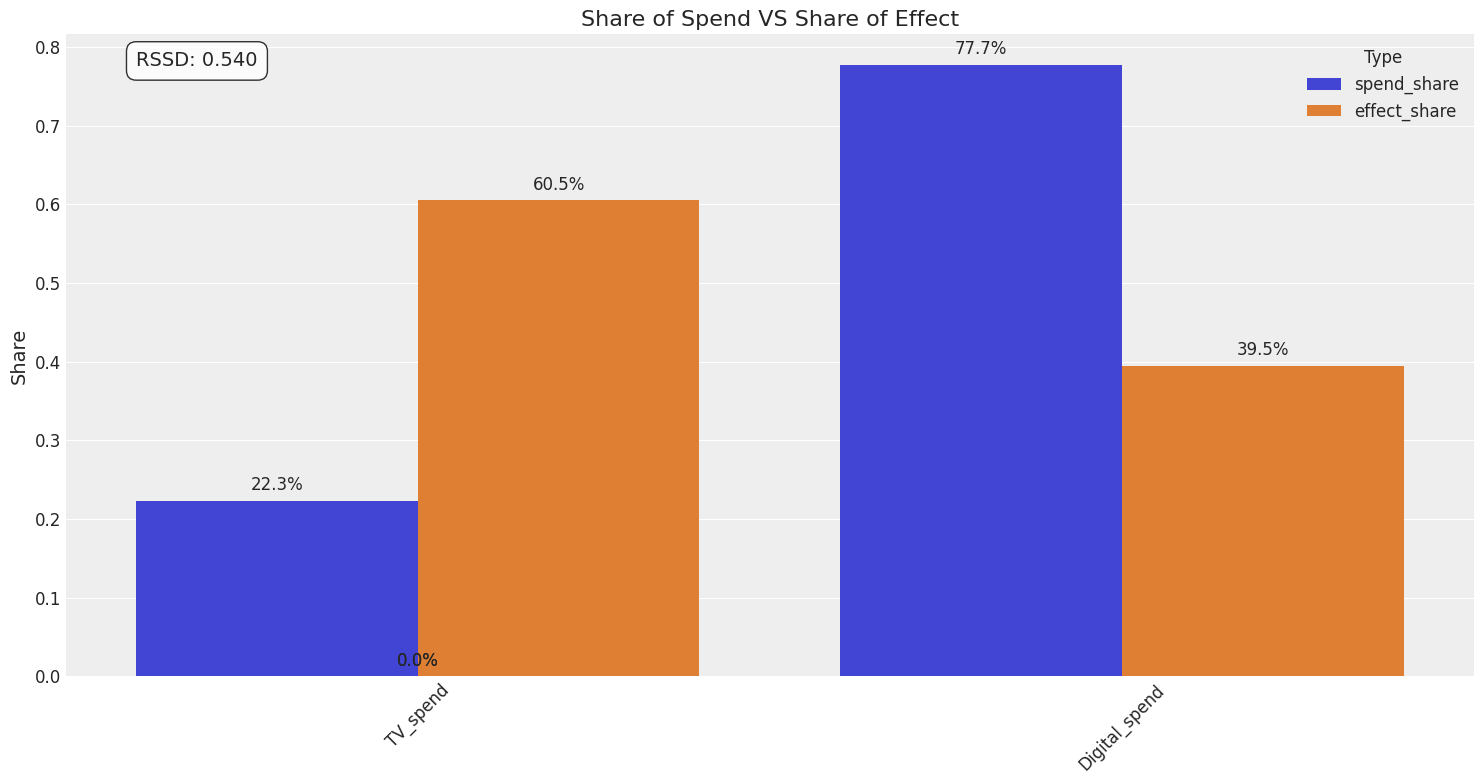

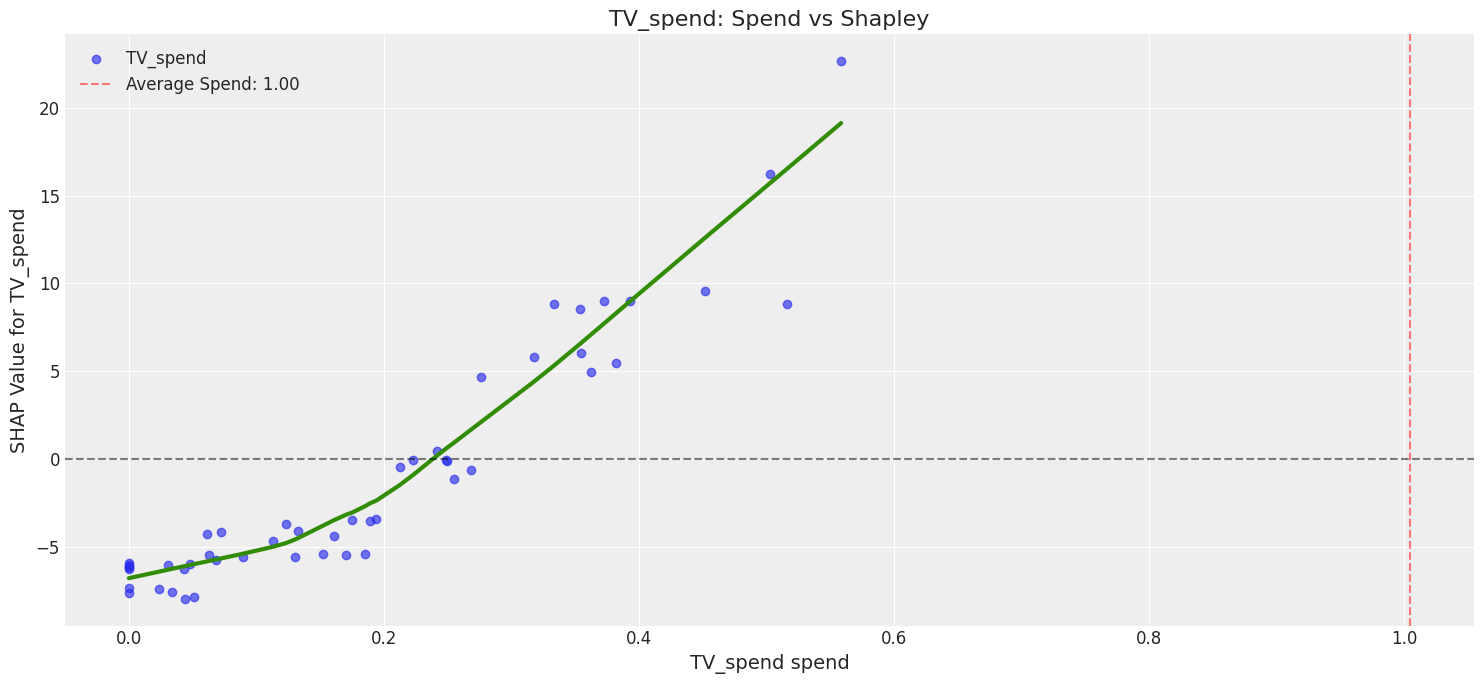

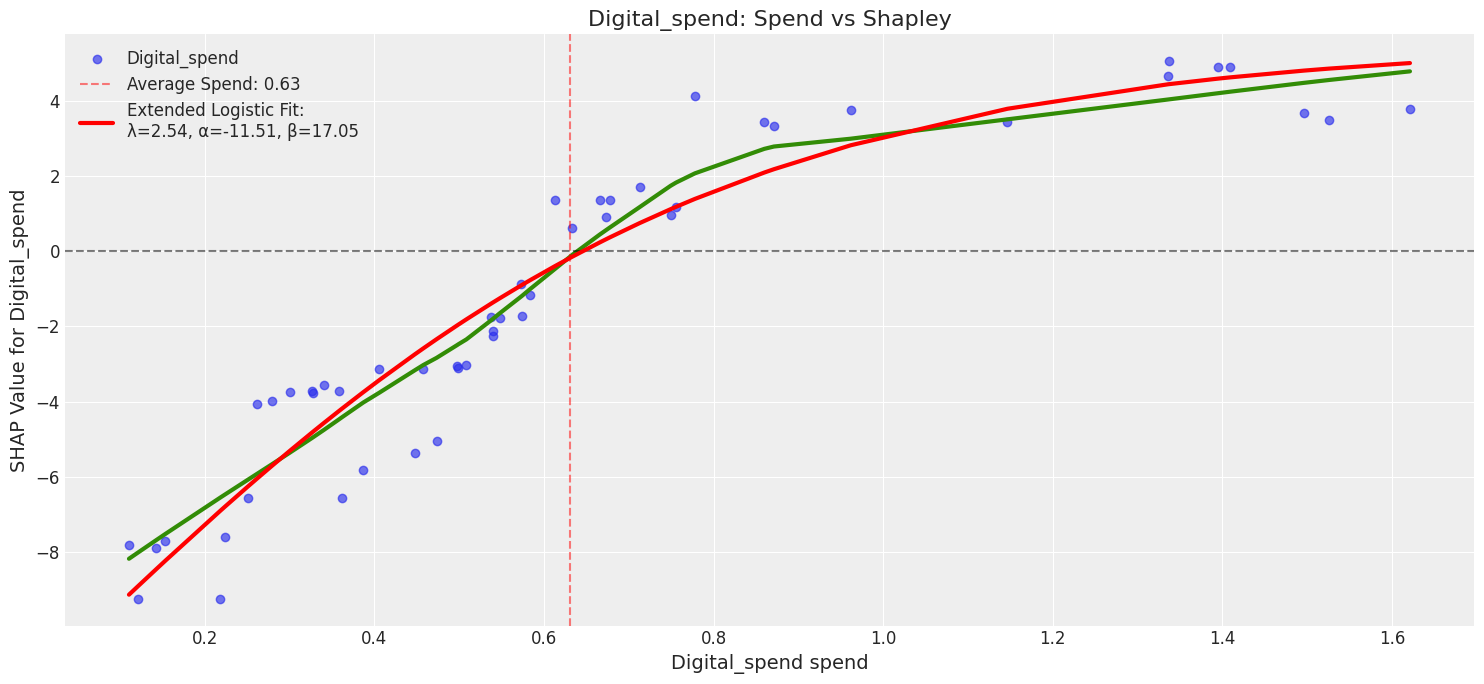


7. Comparing Adstock Parameters Across Models...
               Linear Regression  Gradient Boosting  Ensemble  True Value
TV_spend                0.797855           0.702995  0.749775         NaN
Digital_spend           0.328900           0.366924  0.439445         NaN
TV                           NaN                NaN       NaN    0.825812
Digital                      NaN                NaN       NaN    0.312447


<Figure size 1200x600 with 0 Axes>

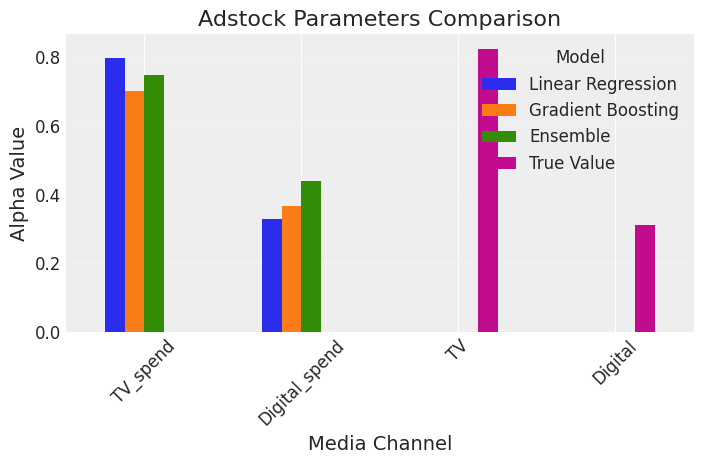


MMM Analysis Complete!


In [ ]:
# Media features
media_columns = ["TV_spend", "Digital_spend"]
spend_df = pd.DataFrame(dataset.sel(country="US").spends, columns=media_columns)

# Trend features

trend = pd.DataFrame({"trend": np.arange(0,len(spend_df))// len(spend_df) })

# Your existing code for Fourier features
n_order = 2
periods = dataset.date.dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

# Combine features
X = pd.concat([trend, spend_df, fourier_features], axis=1)
y = pd.Series(dataset.target.values.reshape(-1,), index=X.index)

# Define alpha ranges for media channels
alpha_ranges = {}
lambda_ranges = {}
for col in media_columns:
    if 'TV' in col.upper():
        alpha_ranges[col] = (0.3, 0.8)
        lambda_ranges[col] = (0,10)
    elif 'RADIO' in col.upper():
        alpha_ranges[col] = (0.1, 0.5)
    elif 'OOH' in col.upper():
        alpha_ranges[col] = (0.1, 0.4)
    elif 'DIGITAL' in col.upper() or 'SEARCH' in col.upper():
        alpha_ranges[col] = (0.0, 0.5)
        lambda_ranges[col] = (0,10)
    else:
        alpha_ranges[col] = (0.1, 0.7)

# Run the complete analysis
results = run_mmm_analysis(
    X=X,
    y=y,
    media_columns=media_columns,
    alpha_ranges=alpha_ranges,
    lambda_ranges=lambda_ranges,
    test_size=50,
    n_trials=30  # You might want to increase this for better results
)


## Bayesian model with diminishing effects

### Index Scaling

In [77]:
index_scaler = StandardScaler()

full_range = np.arange(0, len(dataset.date)).reshape(-1, 1)
full_index_scaled = index_scaler.fit_transform(full_range)

# Split into train and test afterward
index_train_scaled = full_index_scaled[:len(dataset.date)-test_size]
index_test_scaled = full_index_scaled[len(dataset.date)-test_size:]

# Save the scale for other calculations
index_std = index_scaler.scale_.item()

### Data scaling

In [78]:
dataset['target_scaled'] = xr.DataArray(
    np.zeros((len(dataset.date), len(countries))),
    coords={'date': dataset.date, 'country': countries},
    dims=['date', 'country']
)

dataset['z_scaled'] = xr.DataArray(
    np.zeros((len(dataset.date), len(channels), len(countries))),
    coords={'date': dataset.date, 'channel': channels, 'country': countries},
    dims=['date', 'channel', 'country']
)


# Instantiate scalers
target_scaler = MaxAbsScaler()
channel_scaler = MaxAbsScaler()

# Fit scalers
target = dataset.target.values.reshape(-1, 1)
spend = dataset.spends.values.reshape(-1, dataset.spends.shape[-1])

target_train = target[None:-test_size]
target_test = target[-test_size:None]


spend_train = spend[None:-test_size]
spend_test = spend[-test_size:None]

target_scaler.fit(target_train)
channel_scaler.fit(spend_train)


# Then apply scaling
for i, country in enumerate(countries):

    target_scaled = target_scaler.transform(target_train.reshape(-1,1)).flatten()
    target_test_scaled = target_scaler.transform(target_test.reshape(-1,1)).flatten()
    z_scaled = channel_scaler.transform(spend_train)
    z_test_scaled = channel_scaler.transform(spend_test)


In [79]:
channel_share_array = np.zeros((len(channels), len(countries)))

# Get
for i, country in enumerate(countries):
    y = dataset.target.sel(country=country)
    spends = dataset.spends.sel(country=country)

    # Calculate channel shares
    channel_share_array[:,i] = (spends.sum(axis=0) / spends.sum().sum())*len(channels)

### Model specification with time varying parameter

In [ ]:
approx_hsgp_hyperparams(
        full_index_scaled,
        0,
        lengthscale_range=[0.34,1.7],
        cov_func="expquad")


(27, array([3.1556356]))

/Users/damien/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/pymc/model/core.py:988: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
Sampling: [a, alpha, amplitude_trend, b_fourier, b_trend, b_z, lam, likelihood, ls_trend, nu, sigma, trend_coeffs]


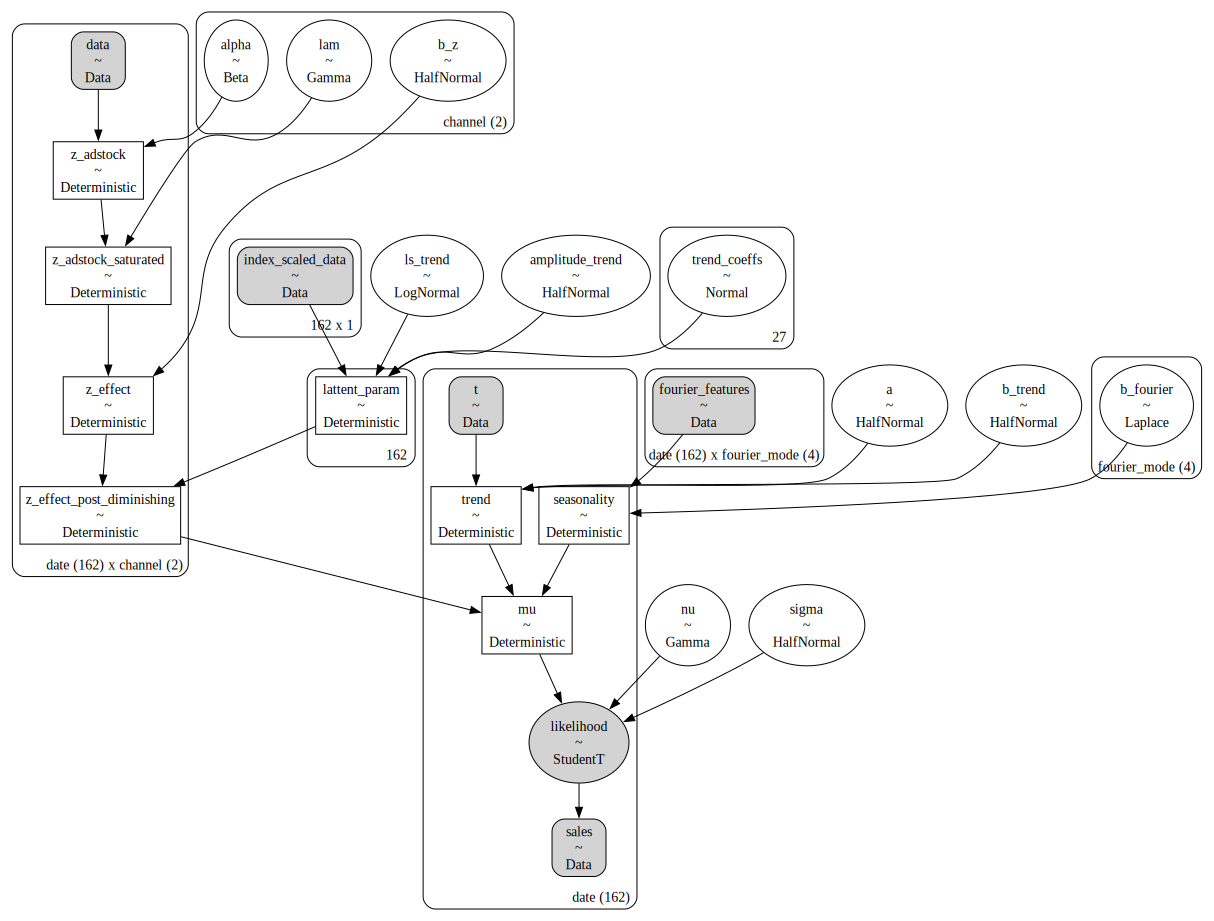

In [ ]:
n_order = 2
dates = dataset.date.values[None:-test_size]
coords = {"channel": channels, "fourier_mode": np.arange(2 * n_order)}


with pm.Model(coords=coords) as tvp_model:
    # --- coords --- #
    tvp_model.add_coord(name="date", values=dates, mutable=True)

    # --- data containers --- #
    index_scaled_data = pm.Data(
        name="index_scaled_data",
        value=index_train_scaled,
    )

    data = pm.Data(
       "data",
       z_scaled,
       dims=("date", "channel"),
      # coords=dataset.date.values
    )

    fourier_feature_data = pm.Data(
        "fourier_features",
        fourier_features[None:-test_size],
        dims=("date", "fourier_mode")
    )

    t_data = pm.Data(
        "t",
        t_train,
        dims="date"
    )

    sales_data = pm.Data(
        "sales",
        target_scaled,
        dims="date"
    )

    # --- priors --- #
    ## intercept
    a = pm.HalfNormal(name="a", sigma=0.1)
    ## trend
    b_trend = pm.HalfNormal(name="b_trend", sigma=2)
    ## adstock effect
    alpha = pm.Beta(name="alpha", alpha=2, beta=2, dims="channel")
    ## saturation effect
    lam = pm.Gamma(name="lam", alpha=2, beta=1, dims="channel")
    ## seasonality
    b_fourier = pm.Laplace(name="b_fourier", mu=0, b=0.2, dims="fourier_mode")
    ## regressor
    b_z = pm.HalfNormal(name="b_z", sigma=np.array(channel_share_array).reshape(-1,1).flatten(), dims="channel")
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    ## gaussian random walk standard deviation
    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=2)

    ls_trend = pm.LogNormal(name="ls_trend", mu=np.log(1), sigma=1)

    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- model parametrization --- #
    trend = pm.Deterministic(name="trend", var=a + b_trend * t_data, dims="date")
    seasonality = pm.Deterministic(
        name="seasonality", var=pm.math.dot(fourier_feature_data, b_fourier), dims="date"
    )



    # Use ExpQuad for smoother decay transitions
    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)

    # Increase m and c for better approximation quality
    # The documentation recommends higher m values for capturing small-scale variations
    # and higher c values for better handling of boundaries
    gp_trend = pm.gp.HSGP(m=[27], c=3.15, cov_func=cov_trend)

    # Use prior_linearized instead of prior
    phi_trend, sqrt_psd_trend = gp_trend.prior_linearized(index_scaled_data)
    trend_coeffs = pm.Normal("trend_coeffs", size=27)
    lattent_param = pm.Deterministic("lattent_param", phi_trend @ (trend_coeffs * sqrt_psd_trend))

    z_adstock = pm.Deterministic(
        name="z_adstock", var=geometric_adstock(x=data, alpha=alpha, l_max=8, normalize=True), dims=("date","channel")
    )

    z_adstock_saturated = pm.Deterministic(
        name="z_adstock_saturated",
        var=logistic_saturation(x=z_adstock, lam=lam),
        dims=("date","channel"),
    )

    z_effect = pm.Deterministic(
        name="z_effect", var=b_z * z_adstock_saturated, dims=("date","channel")
    )

    z_effect_post_diminishing = pm.Deterministic(
        name="z_effect_post_diminishing", var=lattent_param[:, None] * z_effect, dims=("date", "channel")
    )

    mu = pm.Deterministic(name="mu", var=trend + seasonality + z_effect_post_diminishing.sum(axis=1), dims="date")

    # --- likelihood ---
    y = pm.StudentT(name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=sales_data, dims="date")


    # --- prior samples #
    adstock_saturation_diminshing_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(model=tvp_model)

### Prior Predictive Samples

[Text(0.5, 1.0, 'Model - Prior Predictive Samples')]

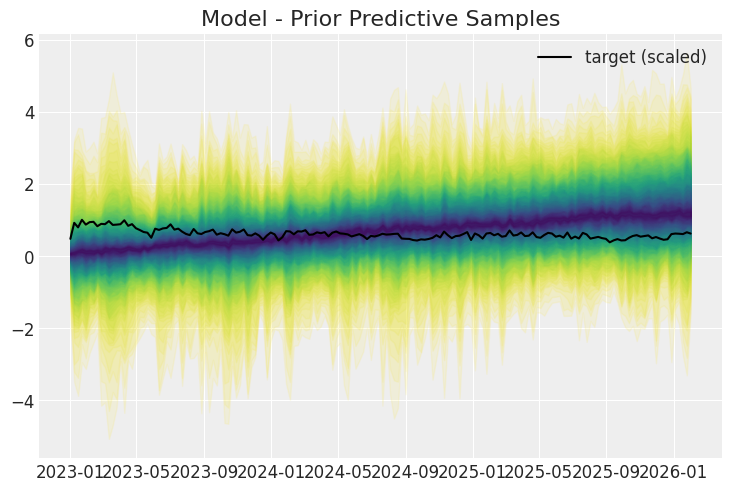

In [ ]:
# useful way to color the distribution
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(adstock_saturation_diminshing_model_prior_predictive.prior_predictive["likelihood"], p, axis=1)
    lower = np.percentile(
        adstock_saturation_diminshing_model_prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=dates,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(x=dates, y=target_scaled, color="black", label="target (scaled)", ax=ax)
ax.legend()
ax.set(title="Model - Prior Predictive Samples")

### In Sample

In [ ]:
with tvp_model:
    diminishing_model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=2_000,
        target_accept=0.90,
        chains=4,
        idata_kwargs={"log_likelihood": True},
        random_seed=rng
    )
    diminishing_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=diminishing_model_trace,
        random_seed=rng,
        var_names=["likelihood", "lattent_param"],

    )

    diminishing_model_trace.extend(diminishing_model_posterior_predictive)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

### Posterior predictive check 

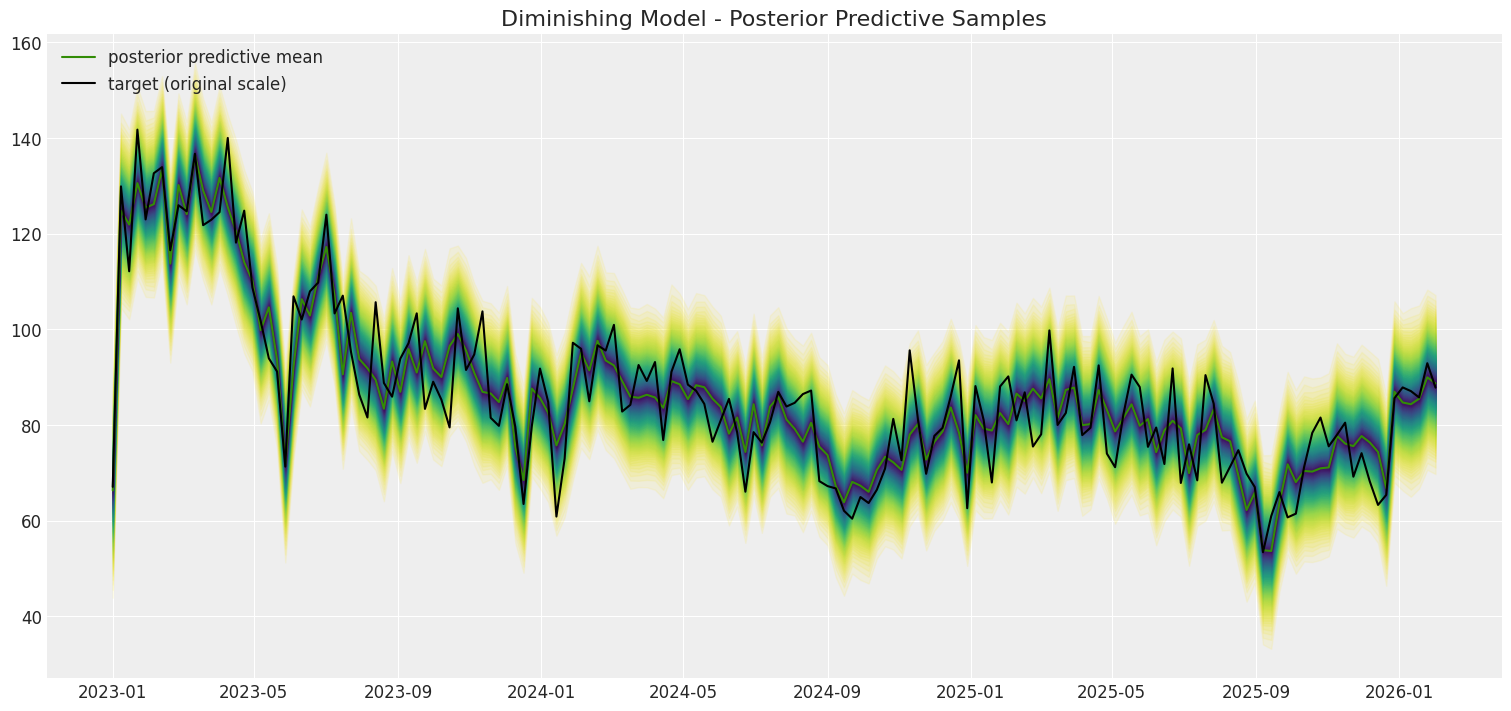

In [ ]:
# Use your exact plot code but with base_model_trace instead of combined



posterior_predictive_likelihood = az.extract(
    data=diminishing_model_posterior_predictive,
    group="posterior_predictive",
    var_names="likelihood",
)

posterior_predictive_likelihood_inv = target_scaler.inverse_transform(
    X=posterior_predictive_likelihood
)

fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=dates,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=dates,
    y=posterior_predictive_likelihood_inv.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=dates,
    y=target_train.flatten(),
    color="black",
    label="target (original scale)",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Diminishing Model - Posterior Predictive Samples");

### Out of sample with carryover 

In [95]:
l_max = 8  # This should match your adstock's l_max parameter

# Combine last l_max training observations with test data
z_combined = np.vstack([z_scaled[-l_max:], z_test_scaled])

# Combine the dates as well
combined_dates = np.concatenate([dataset.date.values[-l_max-test_size:-test_size],
                               dataset.date.values[-test_size:]])

combined_index_scaled = np.concatenate([index_train_scaled[-l_max:None],
                               index_test_scaled])


# Combined t values
t_combined = np.concatenate([t_train[-l_max:], t_test])

# Combined fourier features
fourier_combined = np.vstack([fourier_features[-l_max-test_size:-test_size],
                            fourier_features[-test_size:]])

if target_test_scaled is not None:
    target_combined = np.concatenate([target_scaled[-l_max:], target_test_scaled])
else:
    target_combined = np.concatenate([target_scaled[-l_max:],
                                     np.full(test_size, np.nan)])

# Update model with the combined data
with tvp_model:
    pm.set_data(
        new_data={
            "data": z_combined,
            "t": t_combined,
            "index_scaled_data": combined_index_scaled,
            "fourier_features": fourier_combined
        },
        coords={"date": combined_dates}
    )

    # Generate posterior predictive samples
    combined_posterior_predictive = pm.sample_posterior_predictive(
        trace=diminishing_model_trace,
        var_names=["likelihood","lattent_param"],
        random_seed=rng,
        predictions=True,
        idata_kwargs={"coords": {"date": combined_dates}}
    )

Sampling: [likelihood]


Output()

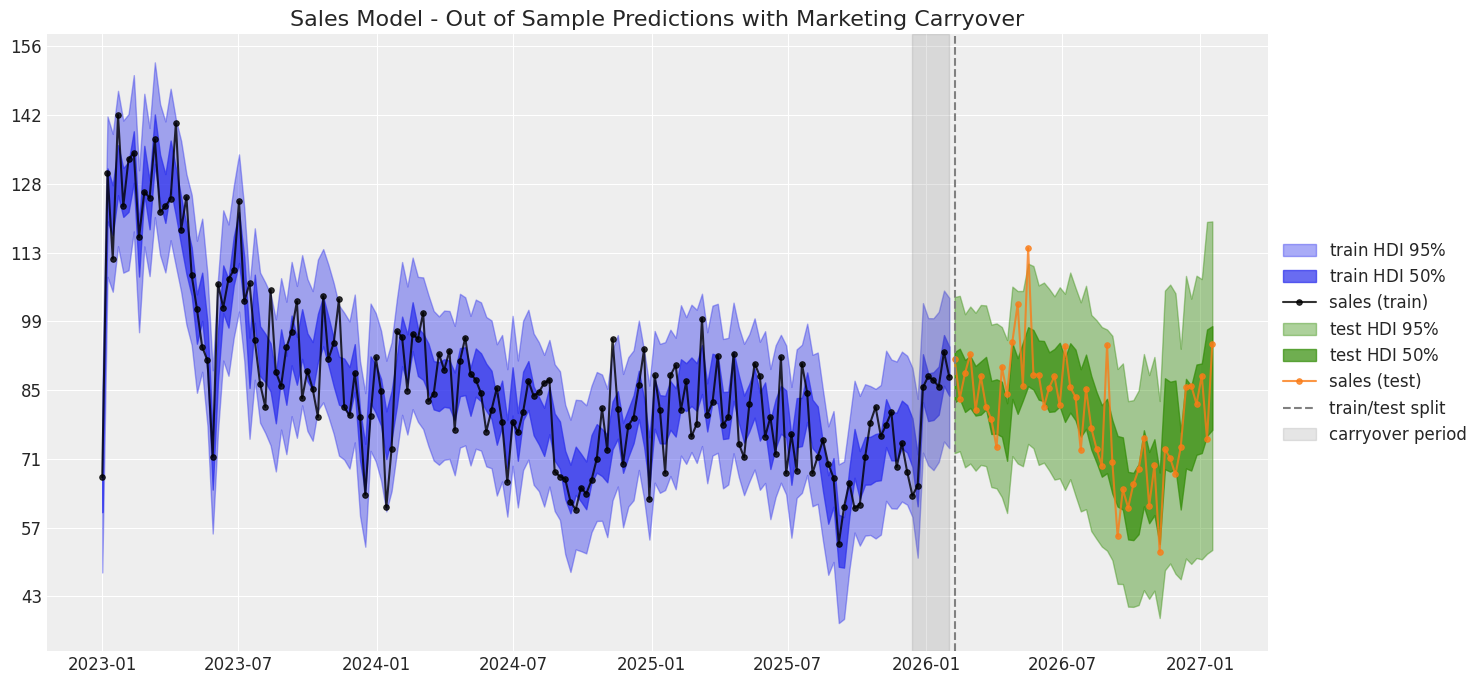

Test Metrics (with carryover effects):
Scaled Space - MAE: 0.0420, RMSE: 0.0529
Original Space - MAE: 5.96, RMSE: 7.50, MAPE: 7.44%


In [96]:
# Use your exact plot code but with base_model_trace instead of combined
fig, ax = plt.subplots(figsize=(15, 7))


# Plot training data predictions and HDI
az.plot_hdi(
    x=dates,
    y=diminishing_model_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=0.95,
    color="C0",
    fill_kwargs={"alpha": 0.4, "label": r"train HDI $95\%$"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=dates,
    y=diminishing_model_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=0.5,
    color="C0",
    fill_kwargs={"alpha": 0.7, "label": r"train HDI $50\%$"},
    smooth=False,
    ax=ax,
)
sns.lineplot(
    x=dates,
    y=target_scaled,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="sales (train)",
    ax=ax,
)

# Extract only the test part (skip carryover observations)
test_dates = dataset.date.values[-test_size:]
test_predictions = combined_posterior_predictive["predictions"]["likelihood"].isel(date=slice(l_max, None))

az.plot_hdi(
    x=test_dates,
    y=test_predictions,
    hdi_prob=0.95,
    color="C2",
    fill_kwargs={"alpha": 0.4, "label": r"test HDI $95\%$"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=test_dates,
    y=test_predictions,
    hdi_prob=0.5,
    color="C2",
    fill_kwargs={"alpha": 0.7, "label": r"test HDI $50\%$"},
    smooth=False,
    ax=ax,
)
sns.lineplot(
    x=test_dates,
    y=target_test_scaled,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="sales (test)",
    ax=ax,
)

# Optional: Add a vertical line at the train/test split
train_test_date = dataset.date.values[-test_size]
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")

# Optional: To show carryover period explicitly
carryover_dates = dataset.date.values[-l_max-test_size:-test_size]
ax.axvspan(carryover_dates[0], carryover_dates[-1], alpha=0.2, color='gray', label='carryover period')

# Apply the formatter to show original scale on y-axis
ax.yaxis.set_major_formatter(FuncFormatter(scaled_to_original))

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Sales Model - Out of Sample Predictions with Marketing Carryover")

plt.tight_layout()
plt.show()

# Display metrics if you have test data
if target_test_scaled is not None:
    # Calculate predictions mean
    test_pred_mean = test_predictions.mean(dim=["chain", "draw"]).values

    # Calculate metrics in scaled space
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    mae_scaled = mean_absolute_error(target_test_scaled, test_pred_mean)
    rmse_scaled = np.sqrt(mean_squared_error(target_test_scaled, test_pred_mean))

    # Calculate metrics in original scale
    test_pred_mean_orig = target_scaler.inverse_transform(test_pred_mean.reshape(-1, 1)).flatten()
    target_test_orig = target_scaler.inverse_transform(target_test_scaled.reshape(-1, 1)).flatten()

    mae_orig = mean_absolute_error(target_test_orig, test_pred_mean_orig)
    rmse_orig = np.sqrt(mean_squared_error(target_test_orig, test_pred_mean_orig))
    mape = np.mean(np.abs((target_test_orig - test_pred_mean_orig) / target_test_orig)) * 100

    print(f"Test Metrics (with carryover effects):")
    print(f"Scaled Space - MAE: {mae_scaled:.4f}, RMSE: {rmse_scaled:.4f}")
    print(f"Original Space - MAE: {mae_orig:.2f}, RMSE: {rmse_orig:.2f}, MAPE: {mape:.2f}%")

### Model parameters

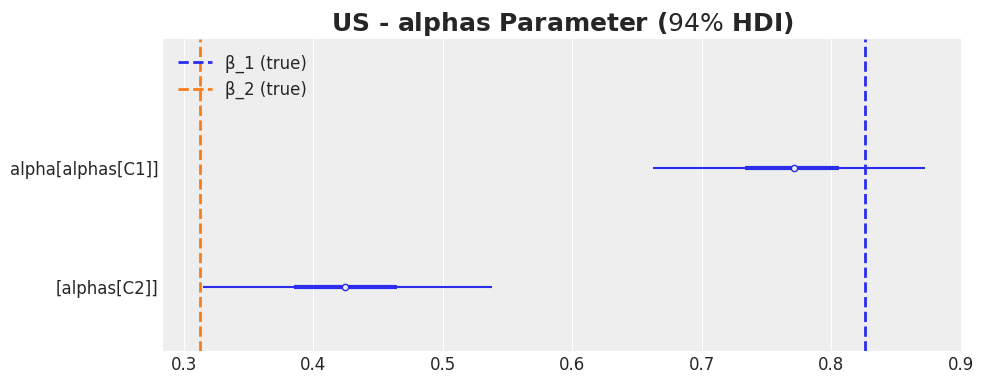

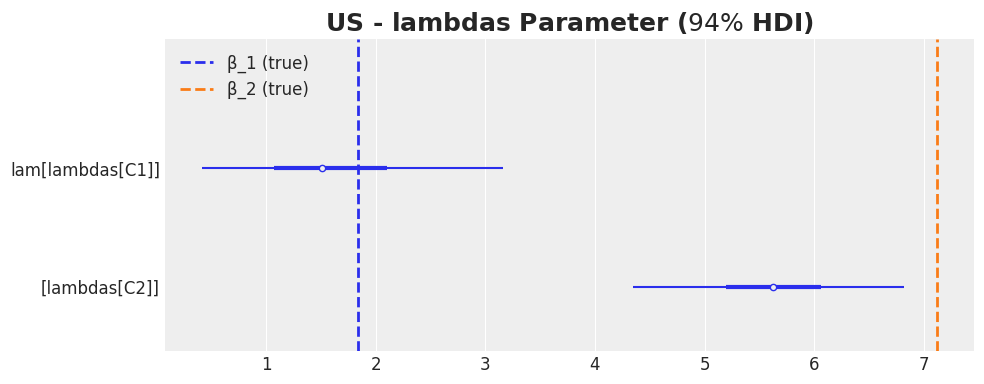

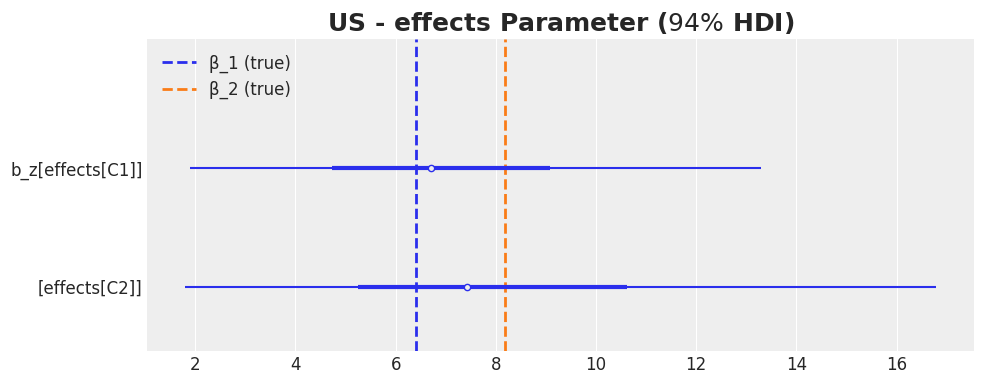

In [ ]:
# Initialize single scalers for all countries
channel_scaler = MaxAbsScaler()
target_scaler = MaxAbsScaler()

# Fit scalers on all data
all_spends = dataset.spends.values.reshape(-1, len(channels))  # Flatten across countries and dates
all_targets = dataset.target.values.reshape(-1, 1)  # Flatten across countries and dates

channel_scaler.fit(all_spends)
target_scaler.fit(all_targets)

# Now recover parameters using these global scalers
recovered_params = {}
for country in countries:
    # Scale posteriors using the global scalers
    alphas = diminishing_model_trace.posterior["alpha"]
    lams = diminishing_model_trace.posterior["lam"] / channel_scaler.scale_
    betas = (diminishing_model_trace.posterior["b_z"] *
             target_scaler.scale_) / 10  # Divide by amplitude

    recovered_params[country] = {
        'alphas': alphas,
        'lambdas': lams,
        'effects': betas
    }

# Plot function remains the same
def plot_param_comparison(param_name, recovered_params, country_params, countries, channels):
    fig, axes = plt.subplots(len(countries), 1, figsize=(10, 4*len(countries)))

    for i, country in enumerate(countries):
        ax = axes[i] if len(countries) > 1 else axes
        data = recovered_params[country][param_name]
        param_data = []
        param_names = []

        for j, channel in enumerate(channels):
            param_data.append(data[:,:,j])
            param_names.append(f"{param_name}[C{j+1}]")
            true_val = country_params[country][param_name][channel]
            ax.axvline(true_val, color=f"C{j}", linestyle="--", linewidth=2,
                      label=f"β_{j+1} (true)")

        combined_data = xr.concat(param_data, dim='channel')
        combined_data = combined_data.assign_coords(channel=param_names)

        az.plot_forest(data=combined_data, combined=True, hdi_prob=0.94, ax=ax)
        ax.legend(loc="upper left")
        ax.set_title(label=f"{country} - {param_name} Parameter ($94\\%$ HDI)",
                    fontsize=18, fontweight="bold")

    plt.tight_layout()

# Plot each parameter
for param in ['alphas', 'lambdas', 'effects']:
    plot_param_comparison(param, recovered_params, country_params, countries, channels)

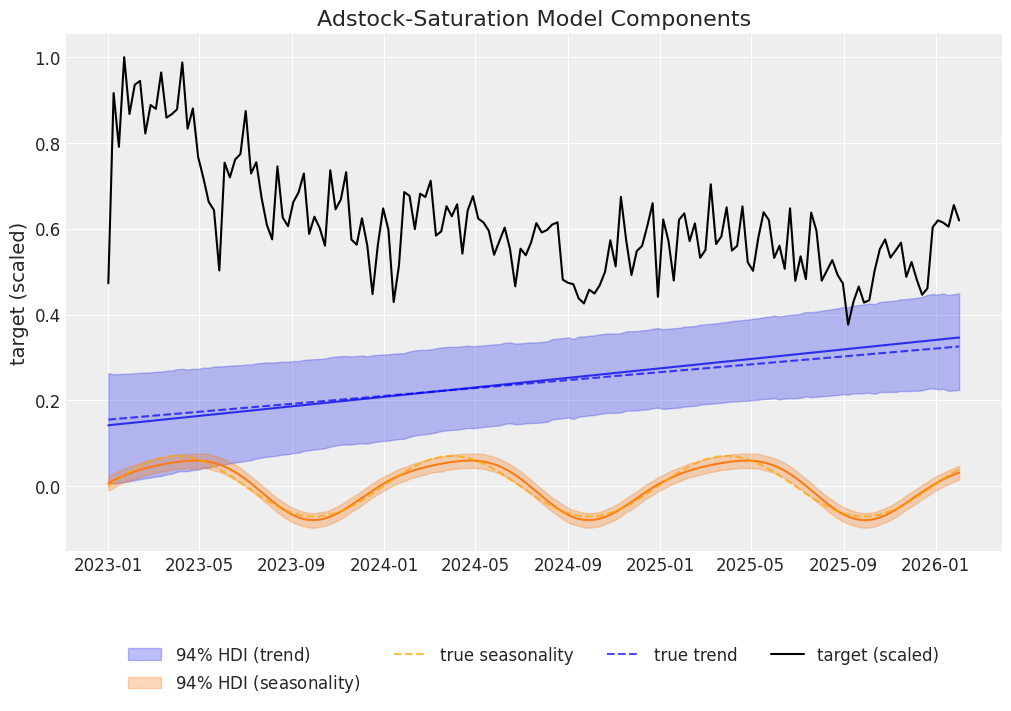

In [ ]:
# compute HDI for all the model parameters
model_hdi = az.hdi(ary=diminishing_model_trace)

fig, ax = plt.subplots(figsize=(10,7))

for i, var_effect in enumerate(["trend", "seasonality"]):
    ax.fill_between(
        x=dates,
        y1=model_hdi[var_effect][:, 0],
        y2=model_hdi[var_effect][:, 1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI ({var_effect})",
    )
    sns.lineplot(
        x=dates,
        y=diminishing_model_trace.posterior[var_effect]
        .stack(sample=("chain", "draw"))
        .mean(axis=1),
        color=f"C{i}",
    )

true_seasonality = target_scaler.transform(
    dataset.seasonality.sel(country=country)[:-test_size].values.reshape(-1, 1)*10
).flatten()

# Plot the true seasonality
sns.lineplot(
    x=dates,
    y=true_seasonality,  # Now properly flattened to 1D
    color="orange",
    alpha=0.7,
    linestyle="--",
    label="true seasonality",
    ax=ax
)


true_trend_and_intercept = target_scaler.transform(
    dataset.trend.sel(country=country)[:-test_size].values.reshape(-1, 1)*10
).flatten() + target_scaler.transform(
    dataset.base_sales.sel(country=country)[:-test_size].values.reshape(-1, 1)*10
).flatten()

# Plot the true trend
sns.lineplot(
    x=dates,
    y=true_trend_and_intercept,  # Now properly flattened to 1D
    color="blue",
    alpha=0.7,
    linestyle="--",
    label="true trend",
    ax=ax
)

sns.lineplot(
    x=dates, y=target_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax
)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)



ax.set(
    title="Adstock-Saturation Model Components",
    ylabel="target (scaled)",
);

#### Focus on the time varying parameter

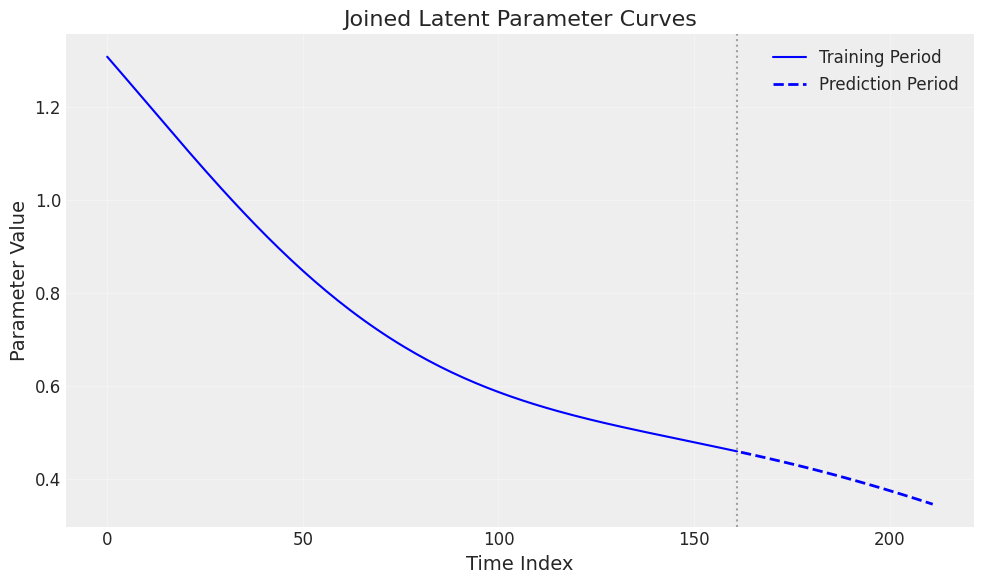

In [99]:
# Get the data from both curves
curve1 = diminishing_model_trace.posterior_predictive["lattent_param"].mean(dim=["chain", "draw"])
curve2 = combined_posterior_predictive.predictions["lattent_param"].mean(dim=["chain", "draw"]).isel(lattent_param_dim_2=slice(l_max, None))

# Create a figure with appropriate size
plt.figure(figsize=(10, 6))

# Plot the first curve
x1 = np.arange(len(curve1))
plt.plot(x1, curve1, 'b-', label='Training Period')

# Plot the extension (second curve)
# Make sure to offset the x values to continue from where curve1 ends
x2 = np.arange(len(curve1), len(curve1) + len(curve2))
plt.plot(x2, curve2, 'b-', linewidth=2, linestyle='--', label='Prediction Period')

# Add a vertical line to show the boundary between training and prediction
plt.axvline(x=len(curve1)-1, color='gray', linestyle=':', alpha=0.7)

# Add labels and title
plt.xlabel('Time Index')
plt.ylabel('Parameter Value')
plt.title('Joined Latent Parameter Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

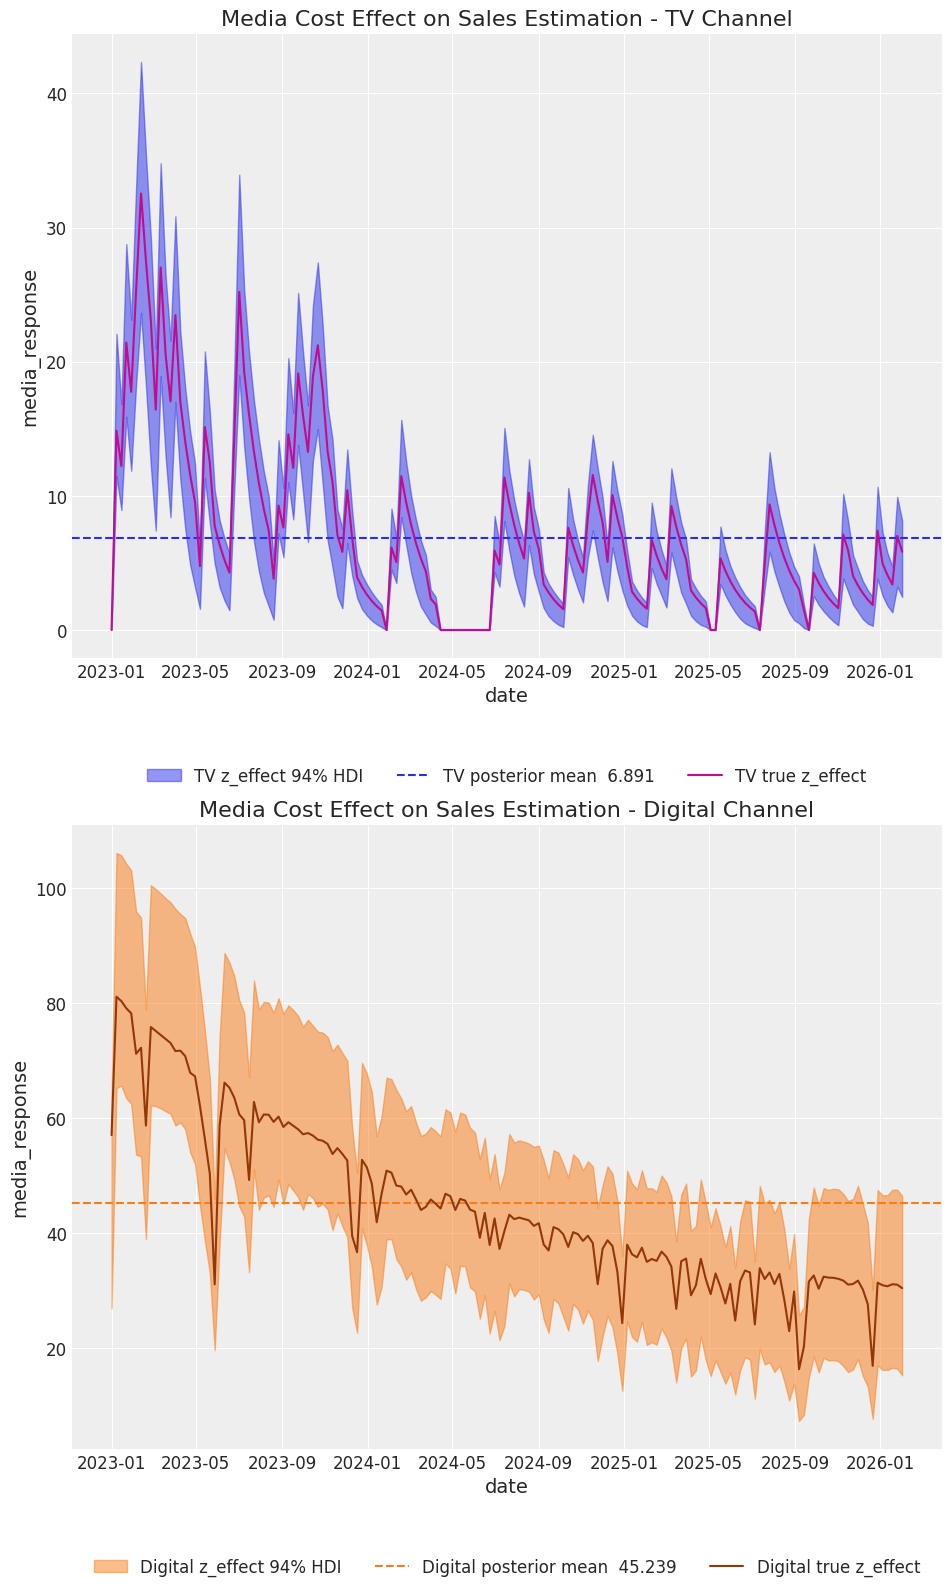

In [ ]:
# For multiple channels, we need to handle each channel separately
z_effect_posterior_samples = []

# Loop through each channel
for channel_idx in range(diminishing_model_trace.posterior["z_effect_post_diminishing"].sizes["channel"]):
    # Extract data for this channel
    channel_data = diminishing_model_trace.posterior["z_effect_post_diminishing"].isel(channel=channel_idx)

    # Apply transformation for this channel
    channel_samples = xr.apply_ufunc(
        lambda x: target_scaler.inverse_transform(X=x.reshape(1, -1)),
        channel_data,
        input_core_dims=[["date"]],
        output_core_dims=[["date"]],
        vectorize=True,
    )

    z_effect_posterior_samples.append(channel_samples)

# Combine the results back into a single DataArray with channel dimension
z_effect_posterior_samples = xr.concat(z_effect_posterior_samples, dim="channel")

# Calculate HDI as before
z_effect_hdi = az.hdi(ary=z_effect_posterior_samples)["z_effect_post_diminishing"]

# Plot for each channel
fig, axes = plt.subplots(nrows=len(dataset.channel), figsize=(10, 8*len(dataset.channel)))
if len(dataset.channel) == 1:
    axes = [axes]  # Make it iterable if there's only one subplot

for i, (ax, channel) in enumerate(zip(axes, dataset.channel.values)):
    ax.fill_between(
        x=dataset.date[:-test_size],
        y1=z_effect_hdi.sel(channel=channel)[:, 0],
        y2=z_effect_hdi.sel(channel=channel)[:, 1],
        color=f"C{i}",
        alpha=0.5,
        label=f"{channel} z_effect 94% HDI",
    )
    ax.axhline(
        y=z_effect_posterior_samples.sel(channel=channel).mean(),
        color=f"C{i}",
        linestyle="--",
        label=f"{channel} posterior mean {z_effect_posterior_samples.sel(channel=channel).mean().values: 0.3f}",
    )

    # Plot the original data for this channel
    sns.lineplot(
        x="date",
        y="media_response",
        color=f"C{i+3}",
        data=(dataset.media_response.sel(channel=channel)*10).to_dataframe().reset_index()[:-test_size],
        label=f"{channel} true z_effect",
        ax=ax
    )

    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=7)
    ax.set(title=f"Media Cost Effect on Sales Estimation - {channel} Channel")

plt.tight_layout()

In [ ]:
!brew install --cask basictex


==> Downloading https://formulae.brew.sh/api/cask.jws.json
==> Caveats
You must restart your terminal window for the installation of MacTeX CLI
tools to take effect.

Alternatively, Bash and Zsh users can run the command:

  eval "$(/usr/libexec/path_helper)"

==> Downloading https://mirror.ctan.org/systems/mac/mactex/mactex-basictex-20250
==> Downloading from https://mirror.lyrahosting.com/CTAN/systems/mac/mactex/mact
######################################################################### 100.0%
==> Installing Cask basictex
==> Running installer for basictex with sudo; the password may be necessary.
Password:
sudo: a password is required



In [ ]:
#!jupyter nbconvert --to pdf "/Users/damien/my_devs/pymc/pymc_notebooks/notebooks/1_pymc_vs_traditional_models.ipynb"
#!pandoc "/Users/damien/my_devs/pymc/pymc_notebooks/notebooks/1_pymc_vs_traditional_models.ipynb" -o 1_pymc_vs_traditional_models.pdf
#!jupyter nbconvert --to pdf "/Users/damien/my_devs/pymc/pymc_notebooks/notebooks/1_pymc_vs_traditional_models.ipynb"
!jupyter nbconvert --to markdown "/Users/damien/my_devs/pymc/pymc_notebooks/notebooks/1_pymc_vs_traditional_models.ipynb" --stdout | head -20


[NbConvertApp] Converting notebook /Users/damien/my_devs/pymc/pymc_notebooks/notebooks/1_pymc_vs_traditional_models.ipynb to markdown
# PYMC vs traditional machine learning models for MMM

This notebook highlights how MMM can be built leveraging different modelling approaches. 

Its purpose is to show the benefits how probabilistic (bayesian) over frequencist models especially when you have some knowledge domain that you want to leverage and you start facing more complex data patterns.

The notebook is inspired from: 
  * [Juan Orduz](https://juanitorduz.github.io/)'s blog post: ["Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns"](https://juanitorduz.github.io/pymc_mmm/)
  * Slava Kisilevich's blog post: [Improving Marketing Mix Modeling Using Machine Learning Approaches](https://towardsdatascience.com/improving-marketing-mix-modeling-using-machine-learning-approaches-25ea4cd6994b/)

Synthetic data generation is available through MMMDataGenerator class. It m